In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import FFTDataModule
from model import Classifier1DMaxPoolBNModel
from utils.model_utils import unwrap_model

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST = True

random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [23]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    cnn_channel_param = [
        (6, 32, 8, 0, 1),
        (32, 64, 8, 0, 1),
        (64, 128, 8, 0, 1),
        (128, 256, 6, 0, 1),
    ],
    pool_channel_param = [
        (3, 3, 0),
        (3, 3, 0),
        (3, 3, 0),
        None
        
    ],
    linear_channel_param = [
       256, 128, 64
    ],).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes      | Out sizes    
--------------------------------------------------------------------------
0  | cnn      | Sequential  | 281 K  | [10, 6, 257]  | [10, 256, 1] 
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257]  | [10, 32, 250]
2  | cnn.1    | MaxPool1d   | 0      | [10, 32, 250] | [10, 32, 83] 
3  | cnn.2    | BatchNorm1d | 64     | [10, 32, 83]  | [10, 32, 83] 
4  | cnn.3    | ReLU        | 0      | [10, 32, 83]  | [10, 32, 83] 
5  | cnn.4    | Conv1d      | 16.4 K | [10, 32, 83]  | [10, 64, 76] 
6  | cnn.5    | MaxPool1d   | 0      | [10, 64, 76]  | [10, 64, 25] 
7  | cnn.6    | BatchNorm1d | 128    | [10, 64, 25]  | [10, 64, 25] 
8  | cnn.7    | ReLU        | 0      | [10, 64, 25]  | [10, 64, 25] 
9  | cnn.8    | Conv1d      | 65.7 K | [10, 64, 25]  | [10, 128, 18]
10 | cnn.9    | MaxPool1d   | 0      | [10, 128, 18] | [10, 128, 6] 
11 | cnn.10   | BatchNorm1d | 256    | [10, 128, 6]  | [10, 128, 6] 
12 | cnn.11   | ReLU        

In [25]:
print(net)

Classifier1DMaxPoolBNModel(
  (cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
    (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (9): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(128, 256, kernel_size=(6,), stride=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_fea

In [20]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    cnn_channel_param = [
        (6, 32, 8, 0, 3),
        (32, 64, 8, 0, 3),
    ],
    linear_channel_param = [
       512, 256, 128, 64, 32
    ],
    in_feature_shape=500,).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name      | Type        | Params | In sizes      | Out sizes    
---------------------------------------------------------------------------
0  | cnn       | Sequential  | 18.2 K | [10, 6, 500]  | [10, 64, 53] 
1  | cnn.0     | Conv1d      | 1.6 K  | [10, 6, 500]  | [10, 32, 165]
2  | cnn.1     | BatchNorm1d | 64     | [10, 32, 165] | [10, 32, 165]
3  | cnn.2     | ReLU        | 0      | [10, 32, 165] | [10, 32, 165]
4  | cnn.3     | Conv1d      | 16.4 K | [10, 32, 165] | [10, 64, 53] 
5  | cnn.4     | BatchNorm1d | 128    | [10, 64, 53]  | [10, 64, 53] 
6  | cnn.5     | ReLU        | 0      | [10, 64, 53]  | [10, 64, 53] 
7  | linear    | Sequential  | 1.9 M  | [10, 3392]    | [10, 8]      
8  | linear.0  | Linear      | 1.7 M  | [10, 3392]    | [10, 512]    
9  | linear.1  | BatchNorm1d | 1.0 K  | [10, 512]     | [10, 512]    
10 | linear.2  | ReLU        | 0      | [10, 512]     | [10, 512]    
11 | linear.3  | Linear      | 131 K  | [10, 512]     | [10, 256]    
12 | linear.4 

In [21]:
all_layers = unwrap_model(net)            
print("Classifier")
print(*list(enumerate(all_layers)), sep="\n")

Classifier
(0, Conv1d(6, 32, kernel_size=(8,), stride=(3,)))
(1, BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(2, ReLU())
(3, Conv1d(32, 64, kernel_size=(8,), stride=(3,)))
(4, BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(5, ReLU())
(6, Linear(in_features=3392, out_features=512, bias=True))
(7, BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(8, ReLU())
(9, Linear(in_features=512, out_features=256, bias=True))
(10, BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(11, ReLU())
(12, Linear(in_features=256, out_features=128, bias=True))
(13, BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(14, ReLU())
(15, Linear(in_features=128, out_features=64, bias=True))
(16, BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(17, ReLU())
(18, Linear(in_features=64, out_features=32, bias=True))
(19, B

In [12]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    cnn_channel_param = [
        (6, 64, 26, 0, 11),
        (64, 512, 22, 0, 11)
    ],
    linear_channel_param = [
       256, 128, 64, 32
    ],
    in_feature_shape=257,).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name      | Type        | Params | In sizes     | Out sizes   
-------------------------------------------------------------------------
0  | cnn       | Sequential  | 732 K  | [10, 6, 257] | [10, 512, 1]
1  | cnn.0     | Conv1d      | 10.0 K | [10, 6, 257] | [10, 64, 22]
2  | cnn.1     | BatchNorm1d | 128    | [10, 64, 22] | [10, 64, 22]
3  | cnn.2     | ReLU        | 0      | [10, 64, 22] | [10, 64, 22]
4  | cnn.3     | Conv1d      | 721 K  | [10, 64, 22] | [10, 512, 1]
5  | cnn.4     | BatchNorm1d | 1.0 K  | [10, 512, 1] | [10, 512, 1]
6  | cnn.5     | ReLU        | 0      | [10, 512, 1] | [10, 512, 1]
7  | linear    | Sequential  | 175 K  | [10, 512]    | [10, 8]     
8  | linear.0  | Linear      | 131 K  | [10, 512]    | [10, 256]   
9  | linear.1  | BatchNorm1d | 512    | [10, 256]    | [10, 256]   
10 | linear.2  | ReLU        | 0      | [10, 256]    | [10, 256]   
11 | linear.3  | Linear      | 32.9 K | [10, 256]    | [10, 128]   
12 | linear.4  | BatchNorm1d | 256    | [1

In [13]:
all_layers = unwrap_model(net)            
print("Classifier")
print(*list(enumerate(all_layers)), sep="\n")

Classifier
(0, Conv1d(6, 64, kernel_size=(26,), stride=(11,)))
(1, BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(2, ReLU())
(3, Conv1d(64, 512, kernel_size=(22,), stride=(11,)))
(4, BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(5, ReLU())
(6, Linear(in_features=512, out_features=256, bias=True))
(7, BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(8, ReLU())
(9, Linear(in_features=256, out_features=128, bias=True))
(10, BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(11, ReLU())
(12, Linear(in_features=128, out_features=64, bias=True))
(13, BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(14, ReLU())
(15, Linear(in_features=64, out_features=32, bias=True))
(16, BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
(17, ReLU())
(18, Linear(in_features=32, out_features=8, bias=True))


In [6]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = "/nfs/ksdata/tran/HAR_AE/dataset/processed_concat_data_5_labels"

log_save_dir = "lightning_logs"
log_save_name = "18_AE_no_flatten"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_mse",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger],
    callbacks=[EarlyStopping(monitor="val_mse", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

net = AECNN1DBNModel(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    cnn_channel_param = [
        (6, 64, 26, 0, 11),
        (64, 512, 22, 0, 11)
    ],
    linear_channel_param = [
        256, 128, 64
    ],
)

data_module = FFTDataModule(dataset_path=dataset_path, batch_size=batch_size)

trainer.fit(model=net, datamodule=data_module)
trainer.test(model=net, datamodule=data_module)

In [9]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/18_AE_no_flatten/version_2/checkpoints/sample_epoch=3039-step=60800-val_loss=0.000000.ckpt"

data_module = FFTDataModule.load_from_checkpoint(checkpoint_path, dataset_path=dataset_path)
net = AECNN1DBNModel.load_from_checkpoint(checkpoint_path)

trainer = L.Trainer()

trainer.test(model=net, datamodule=data_module)
pred = trainer.predict(model=net, datamodule=data_module)
gt = list(map(lambda x: x[0], iter(data_module.predict_dataloader())))
y = list(map(lambda x: x[1], iter(data_module.predict_dataloader())))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|████████████████| 10/10 [00:00<00:00, 136.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse           0.0004986166022717953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████| 10/10 [00:00<00:00, 94.96it/s]


save_image_dir /nfs/ksdata/tran/HAR_AE/lightning_logs/version_12/compare_img


/tmp/ipykernel_126459/1689595640.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(6,2, figsize=(10, 12))


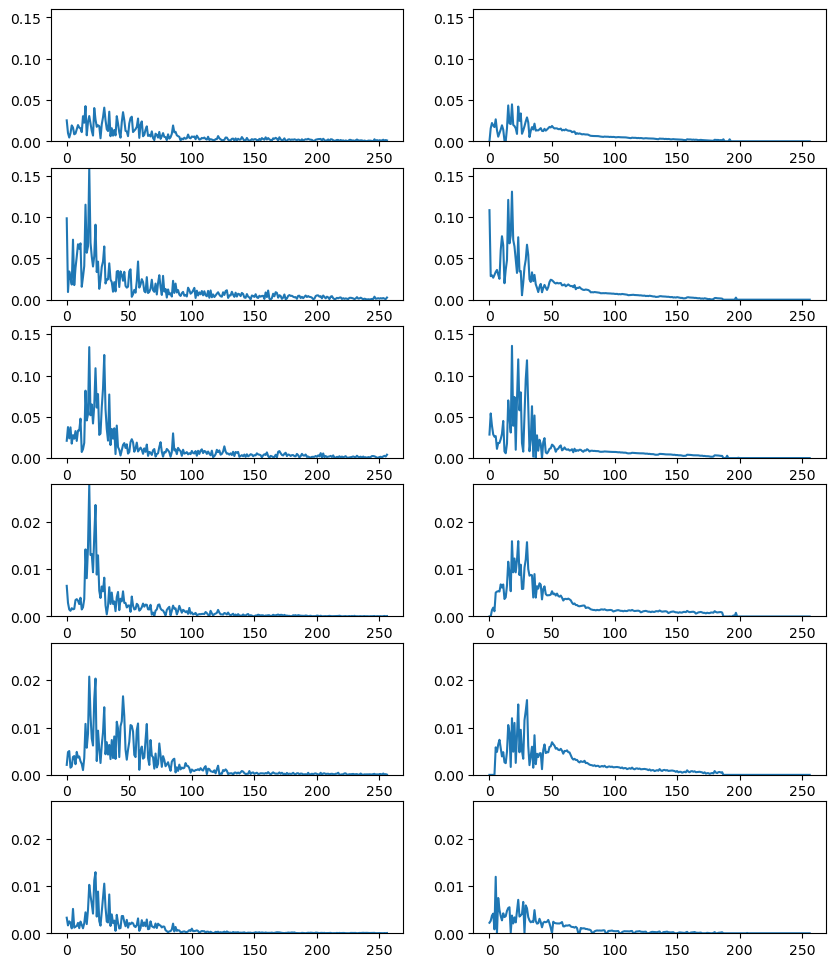

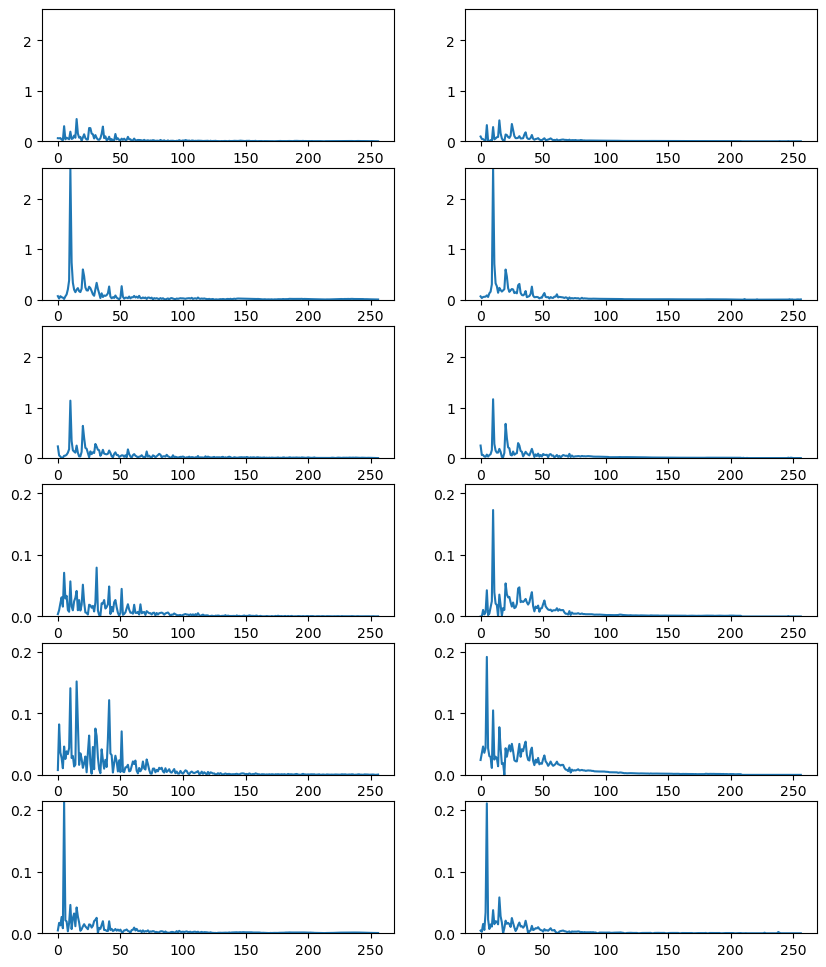

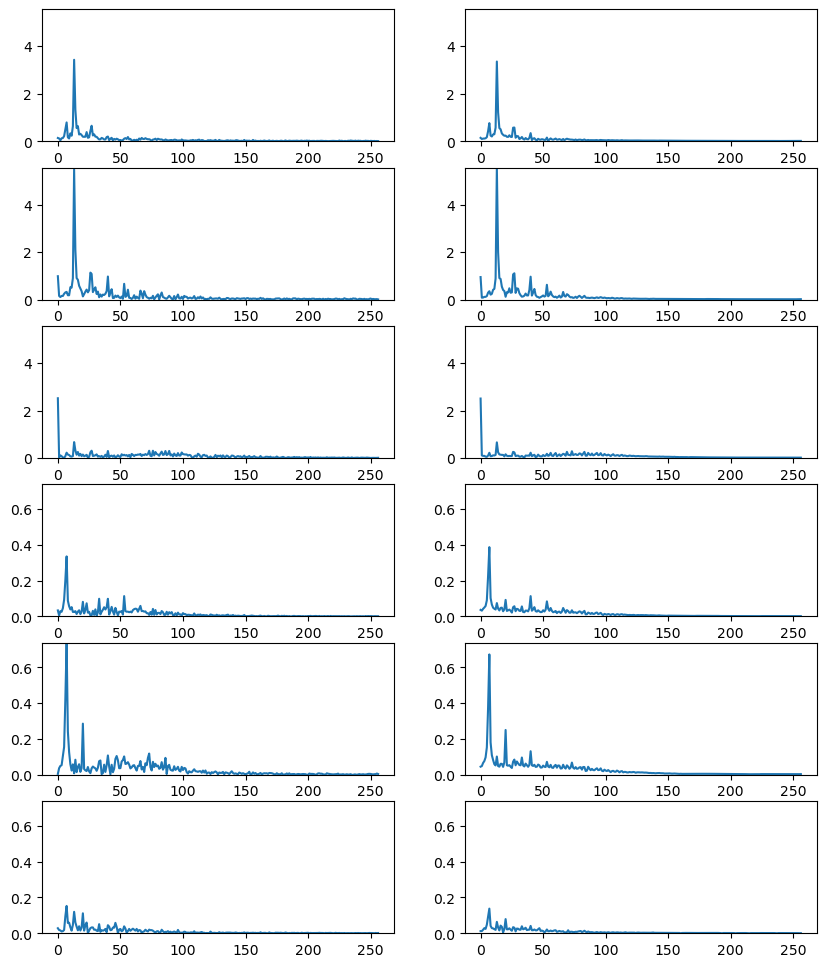

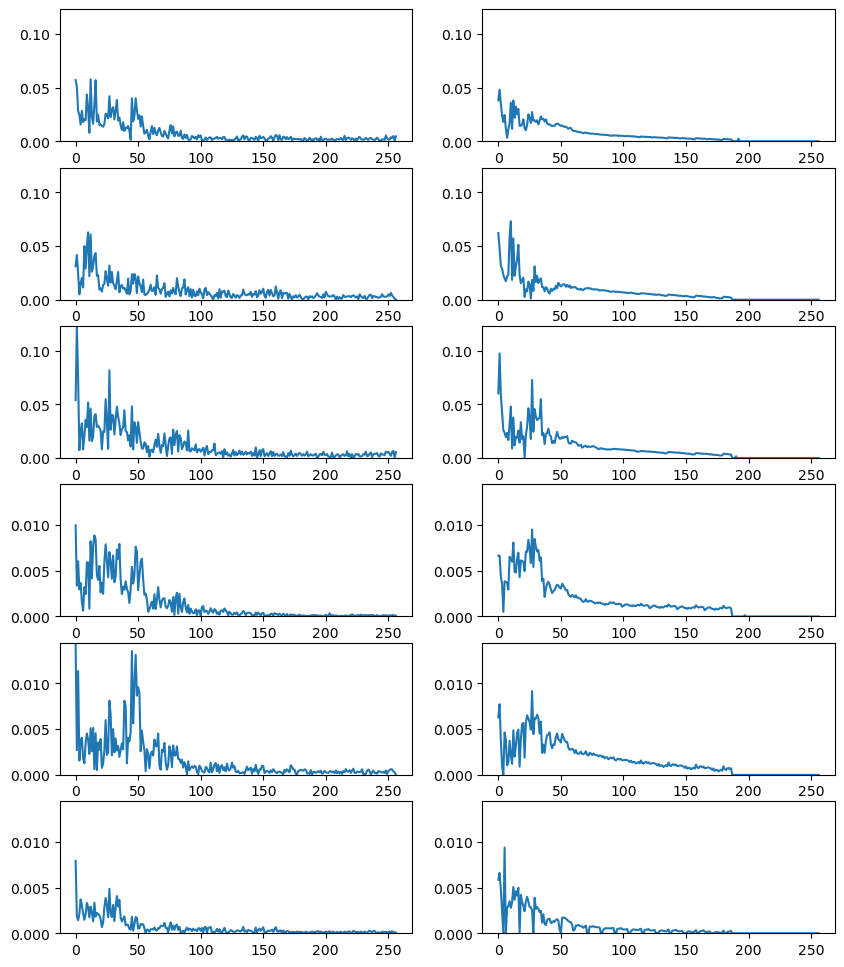

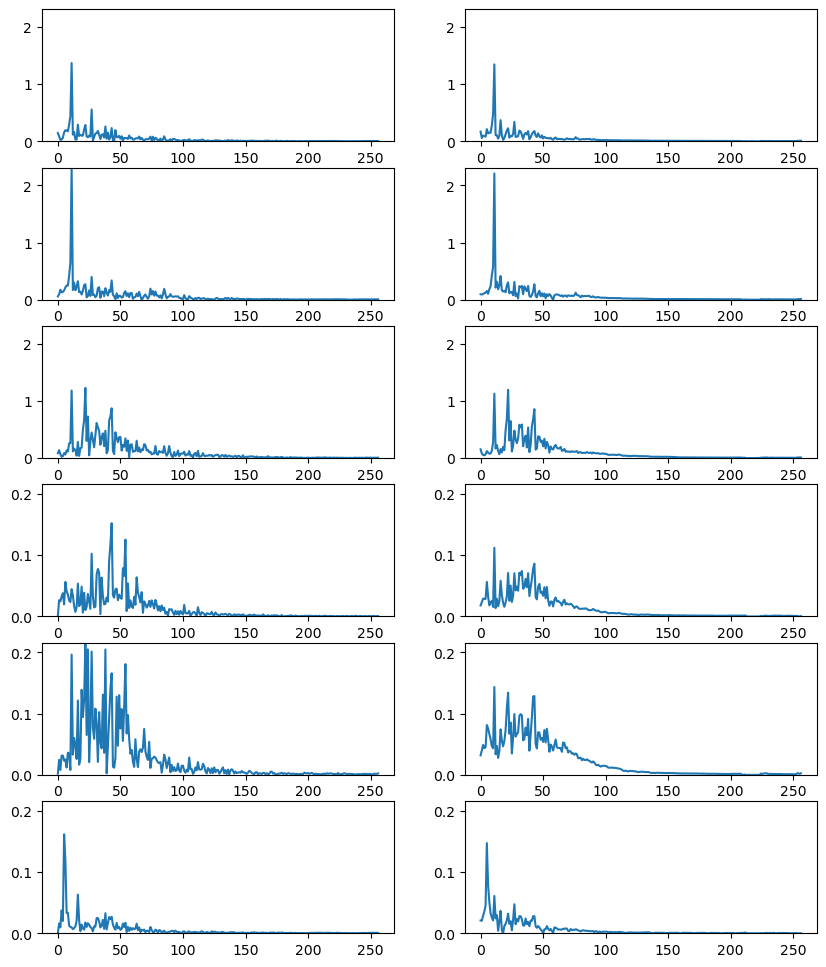

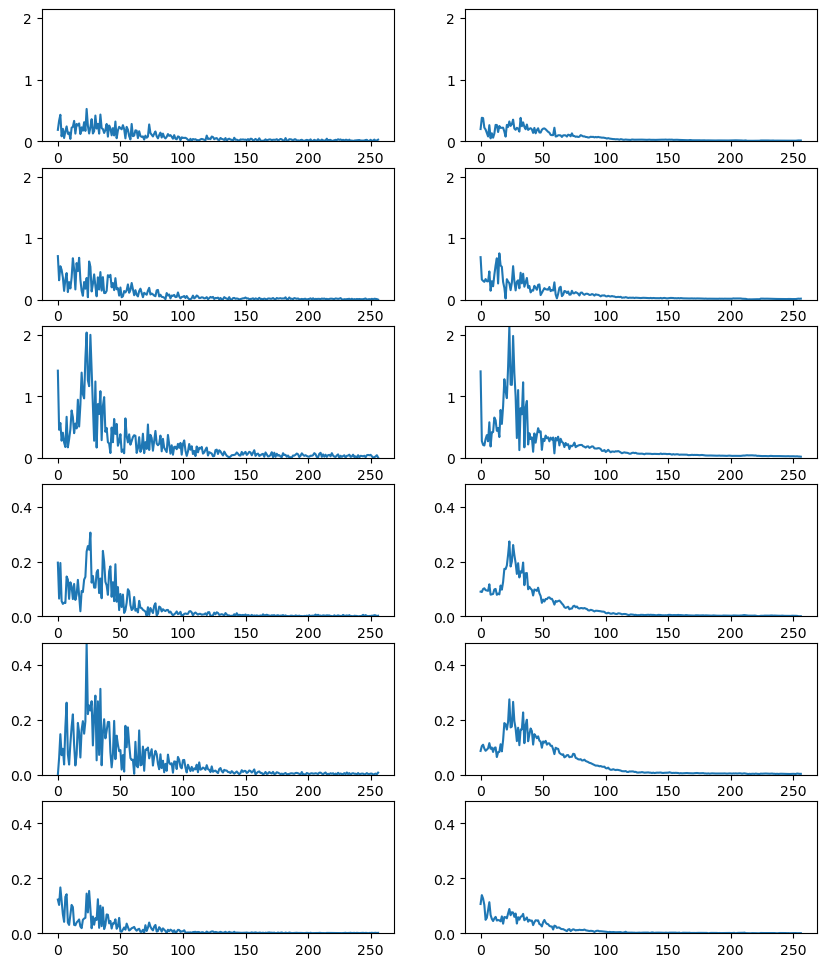

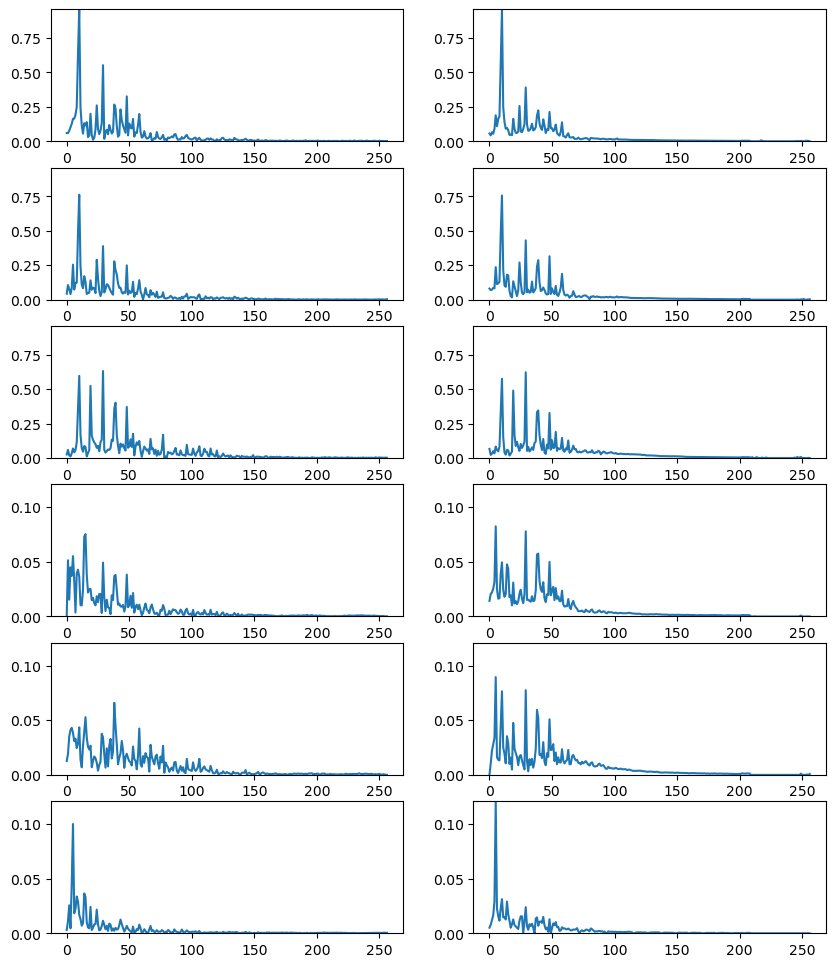

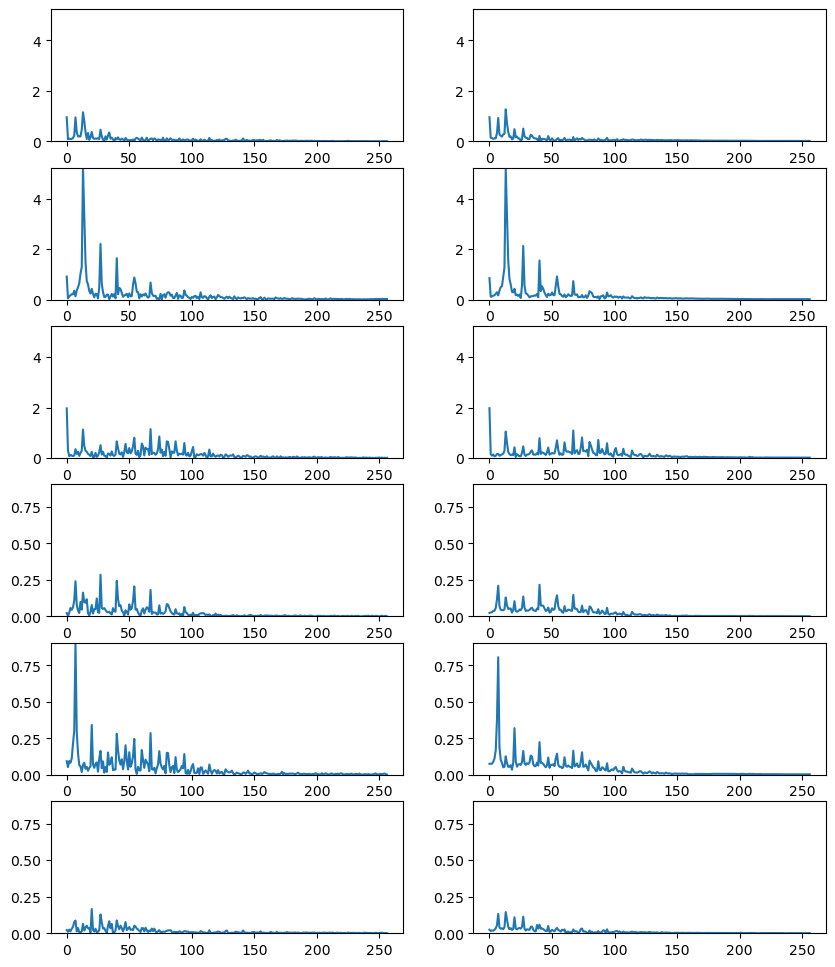

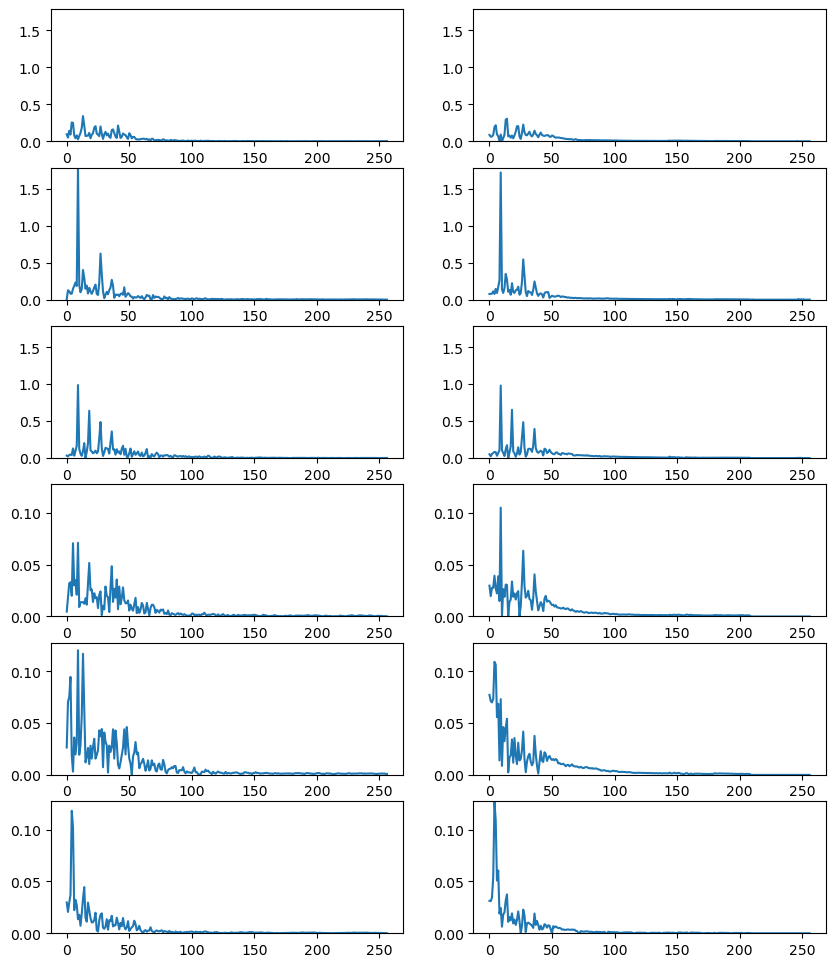

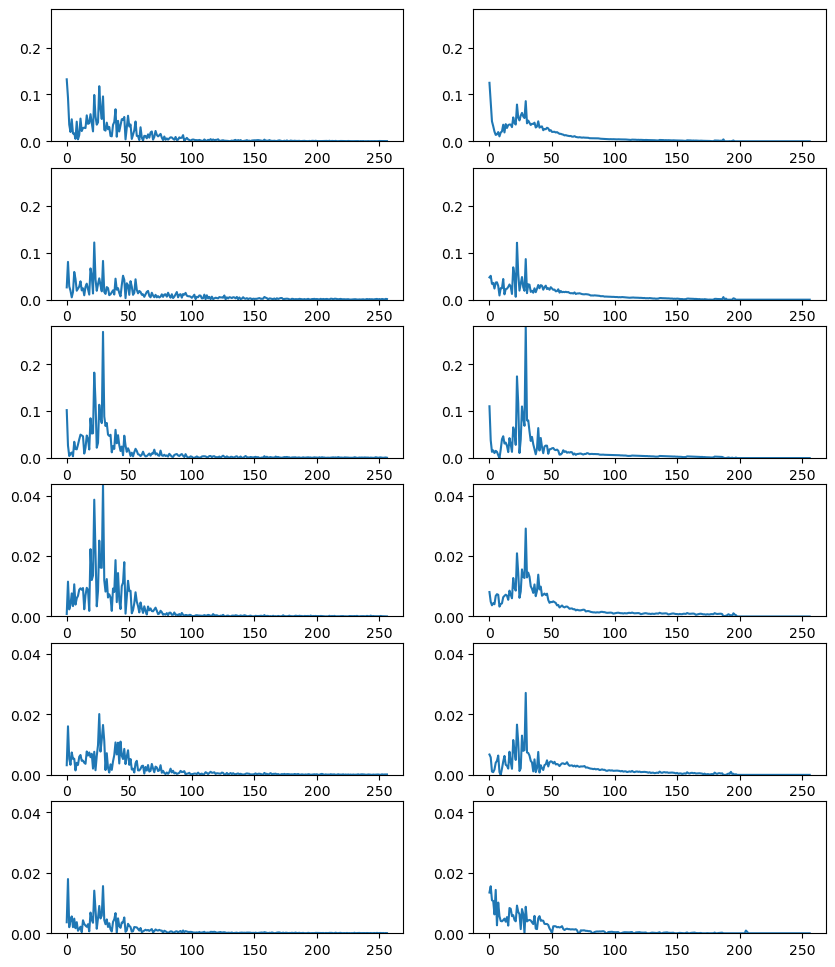

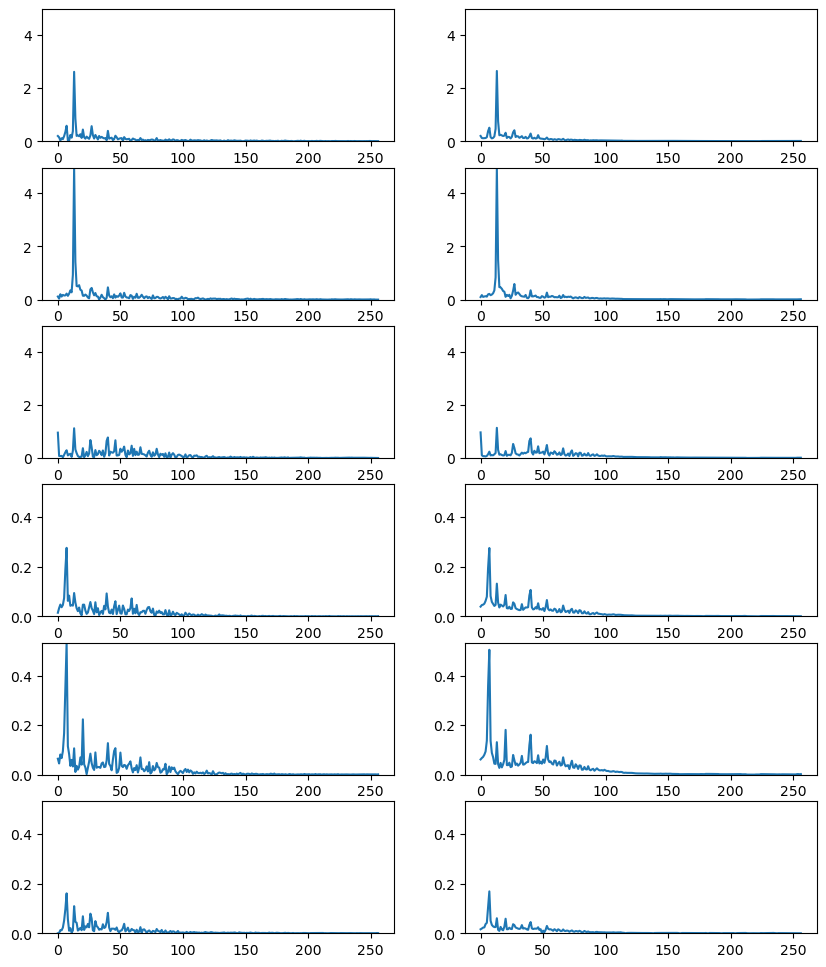

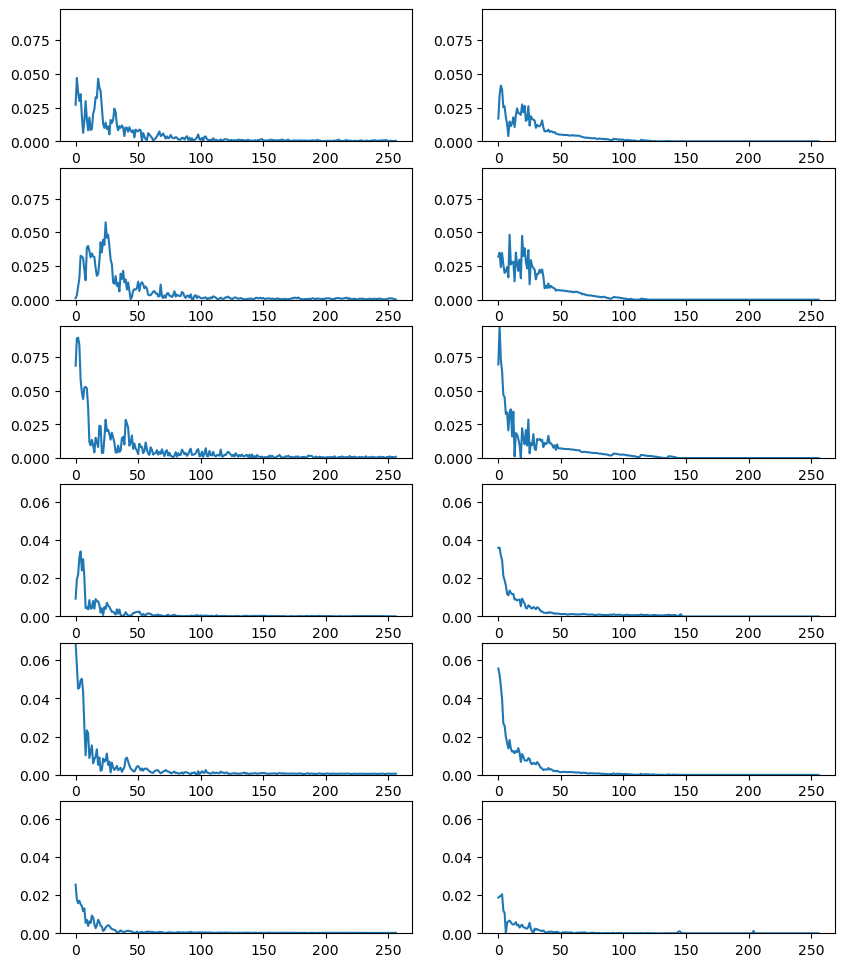

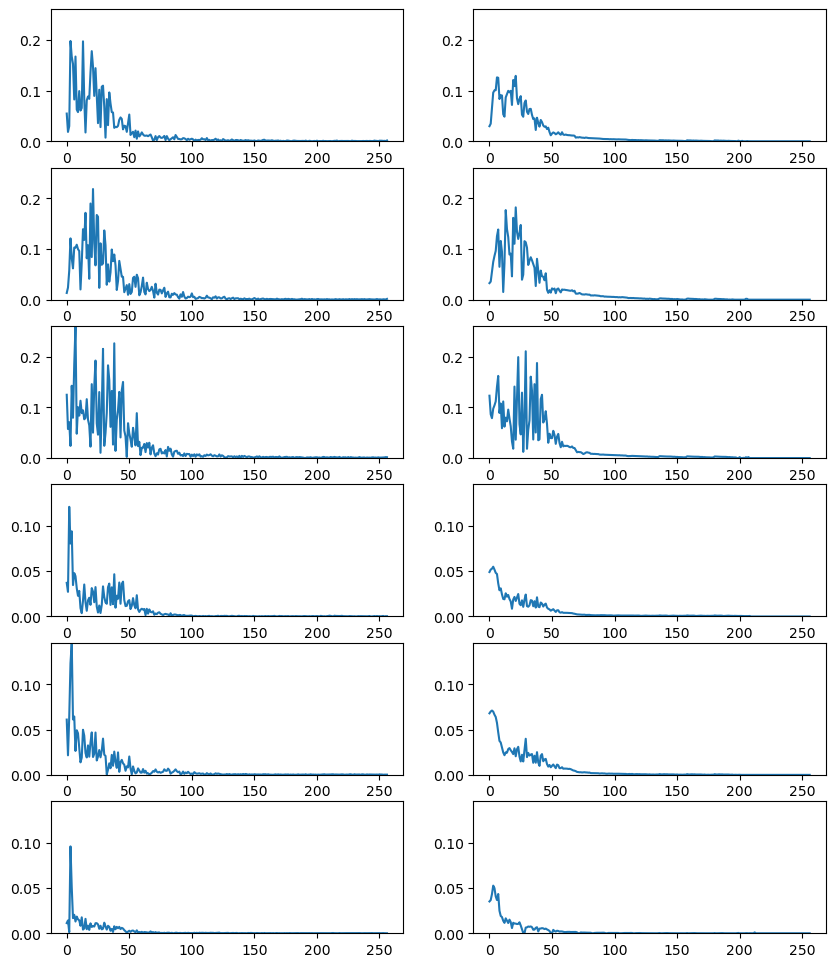

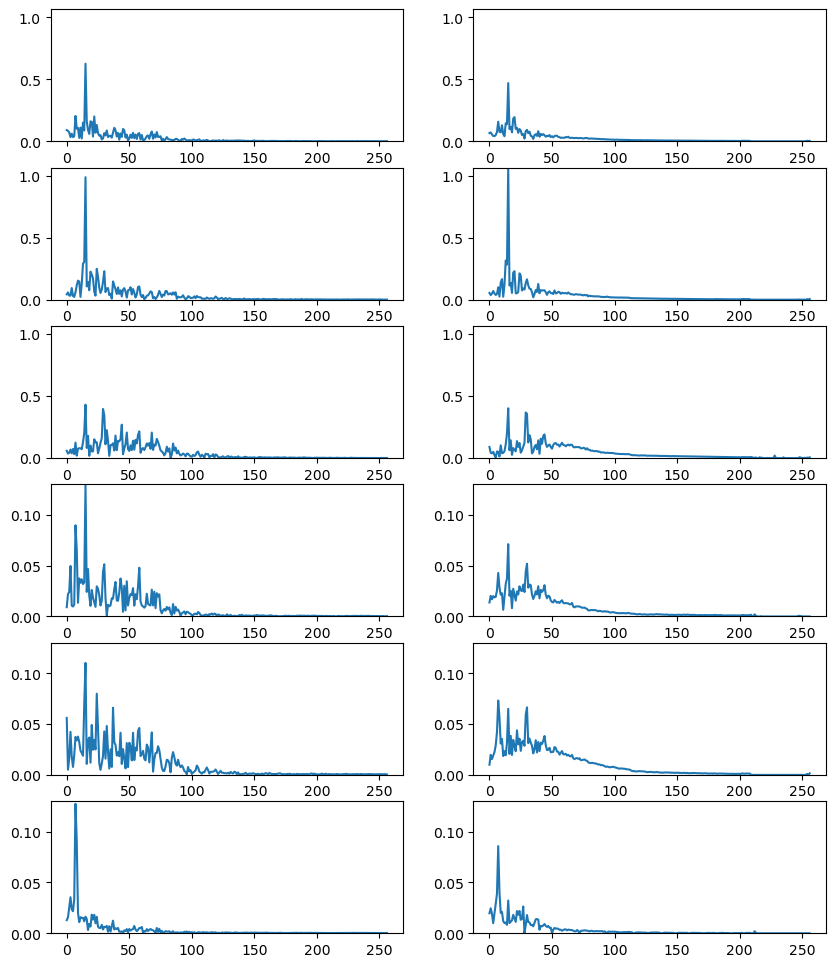

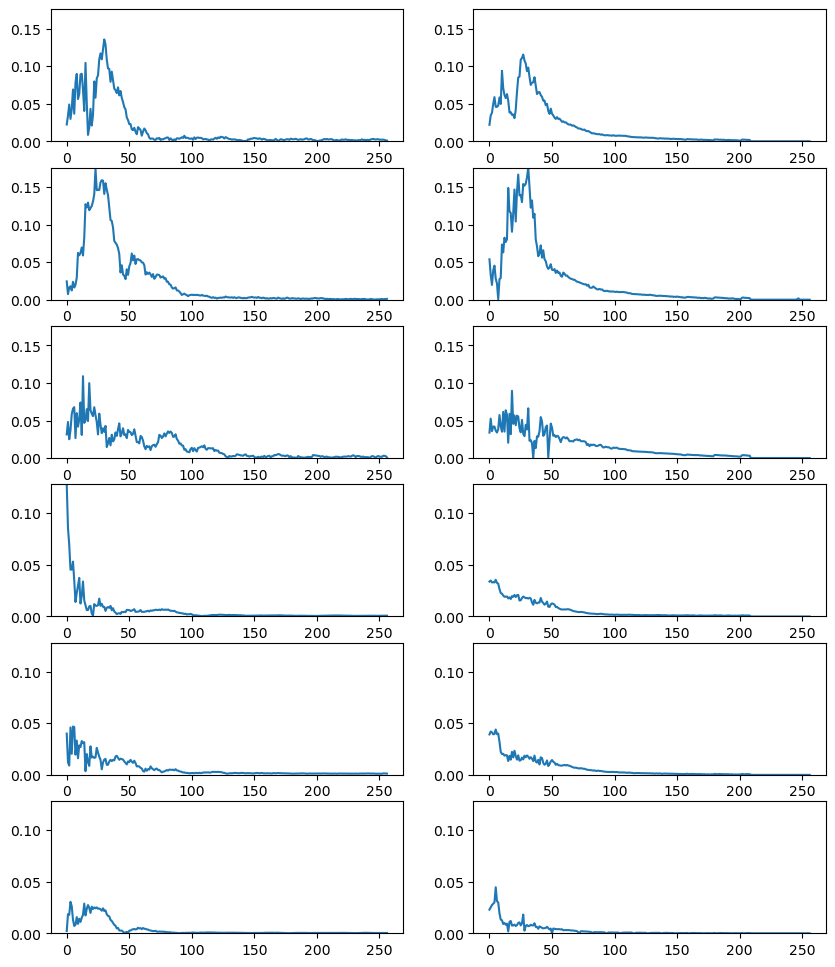

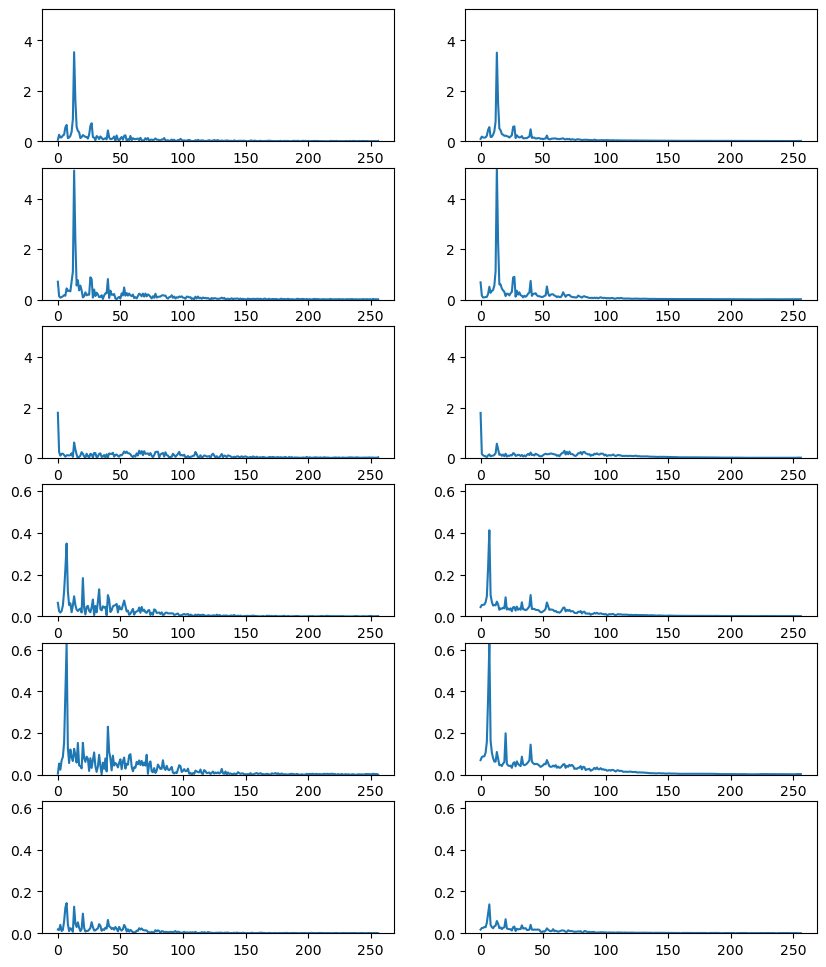

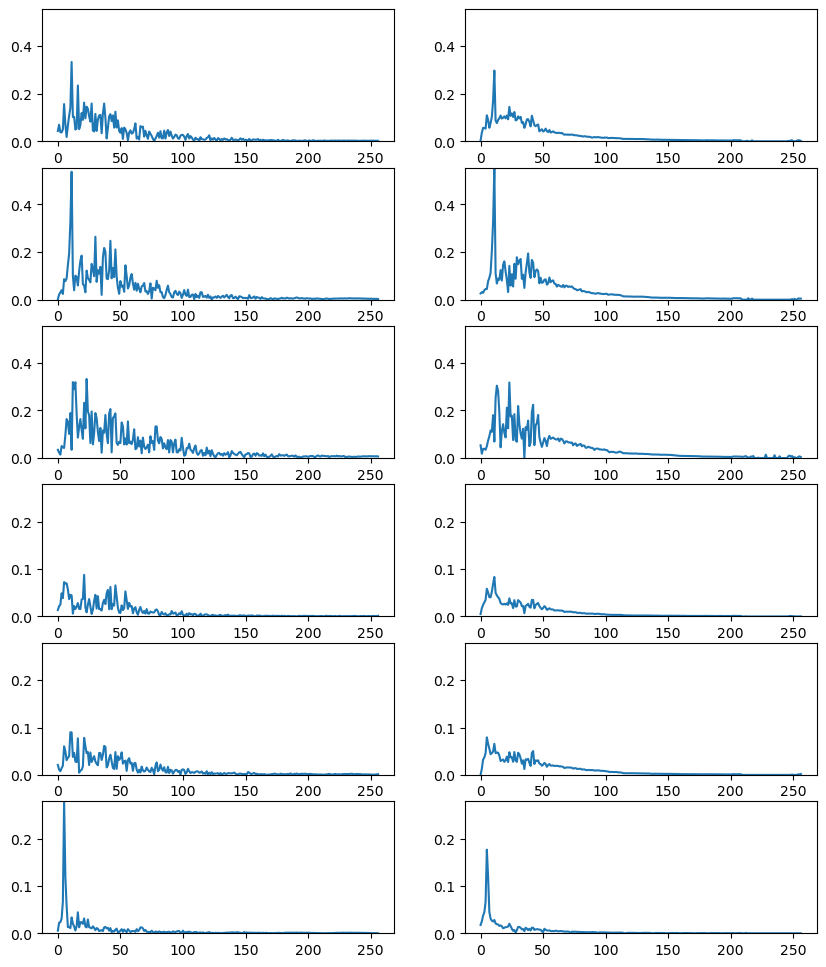

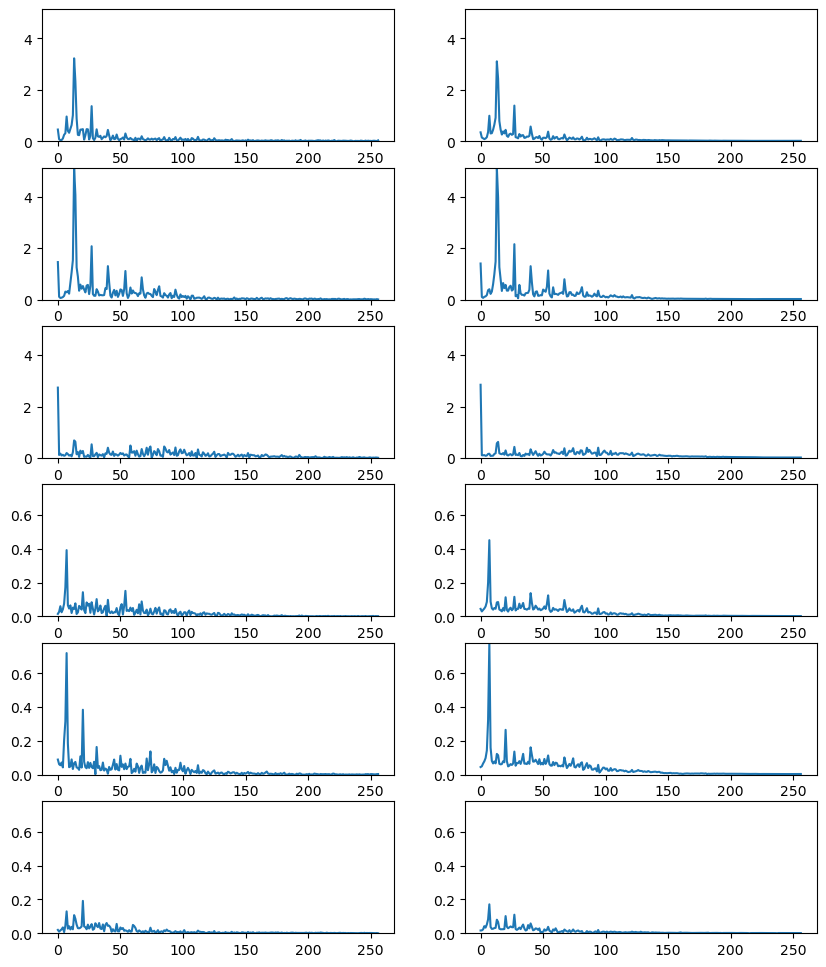

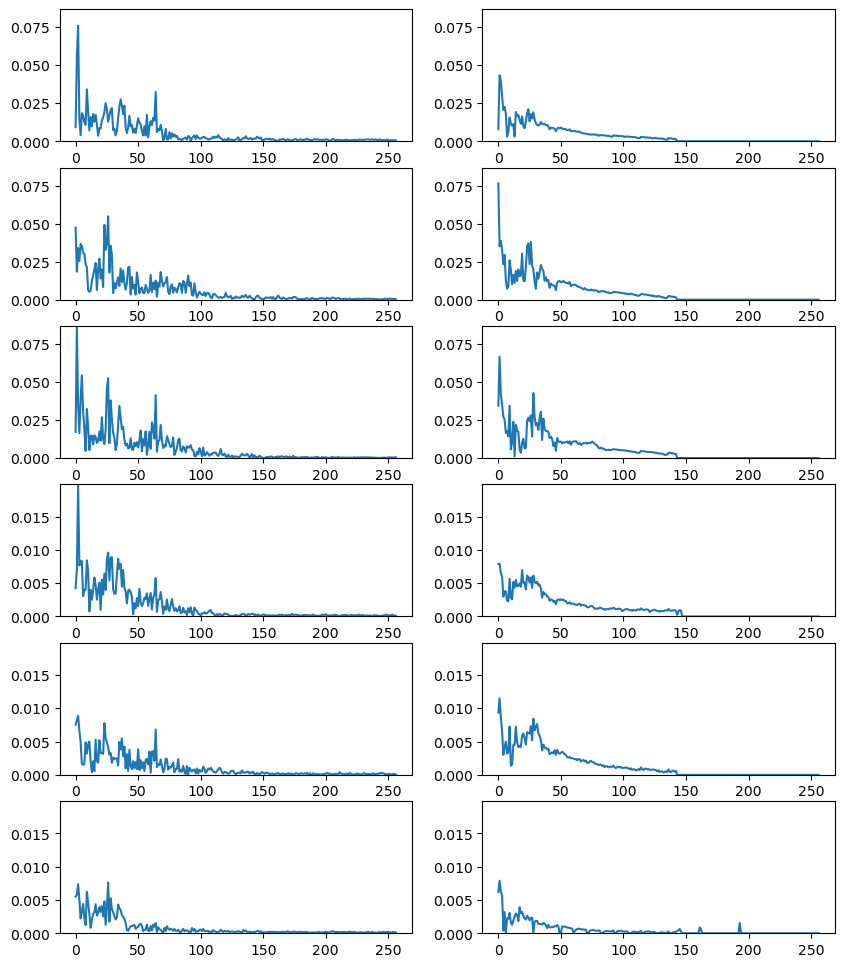

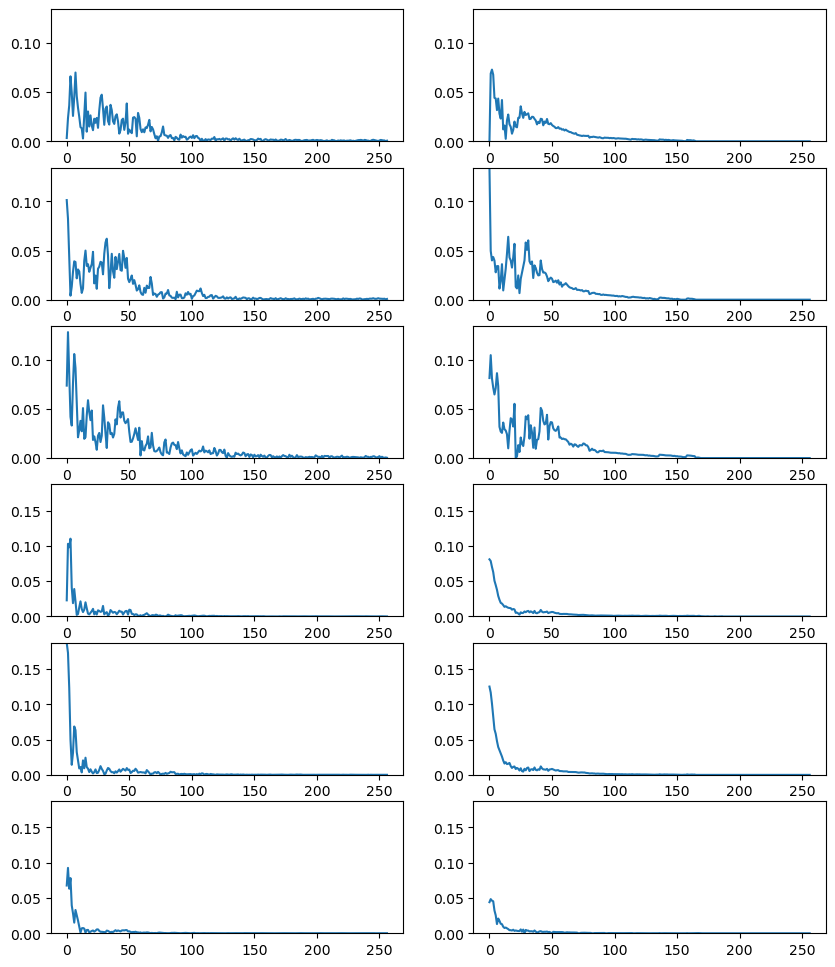

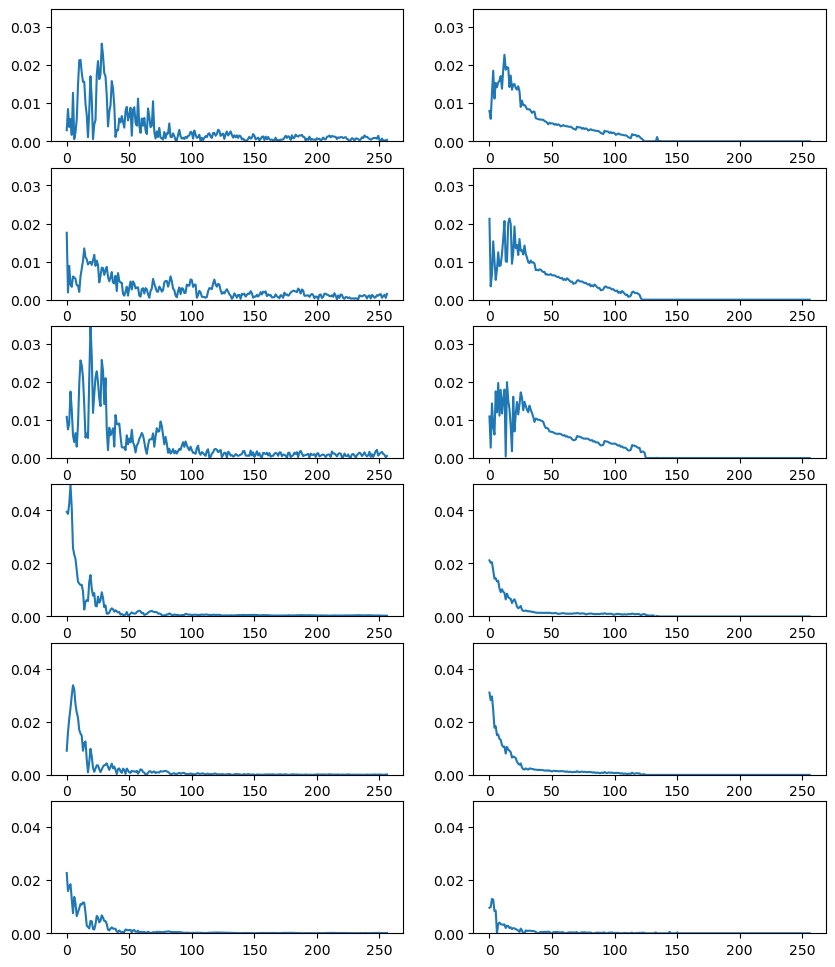

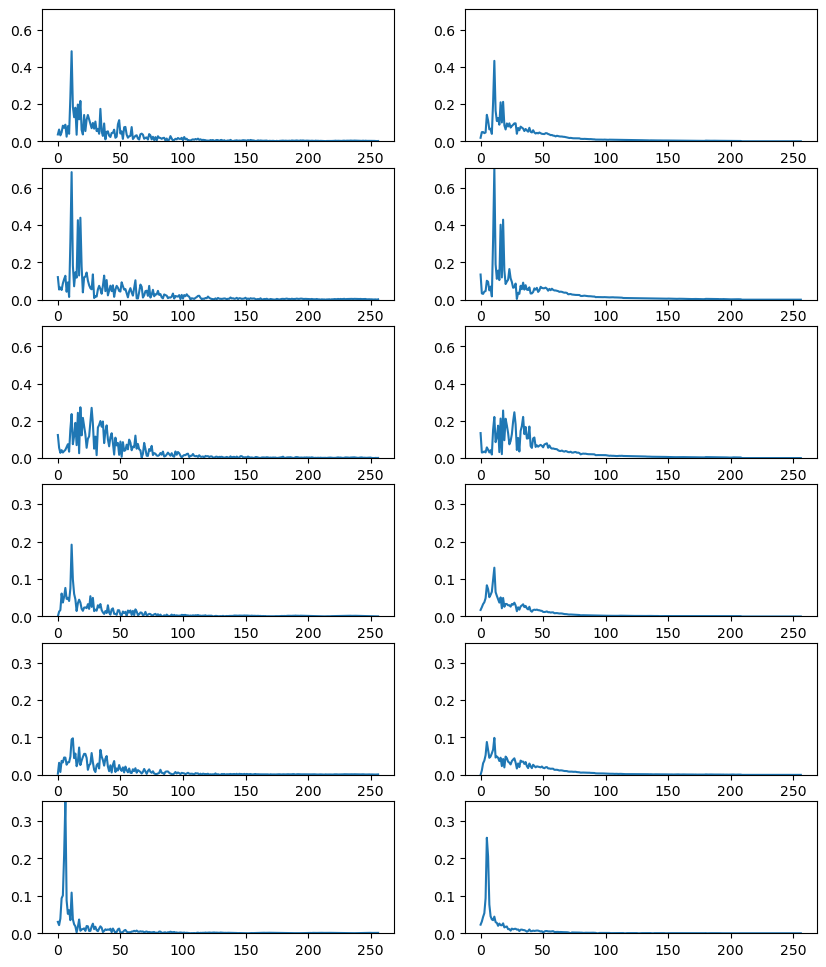

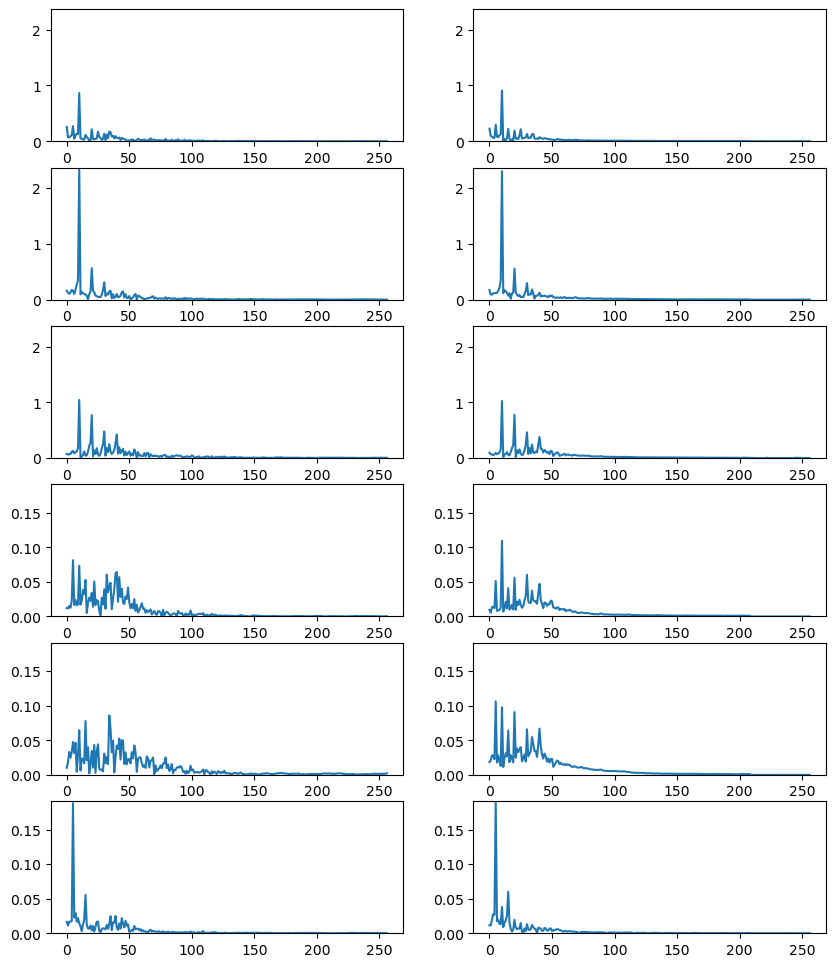

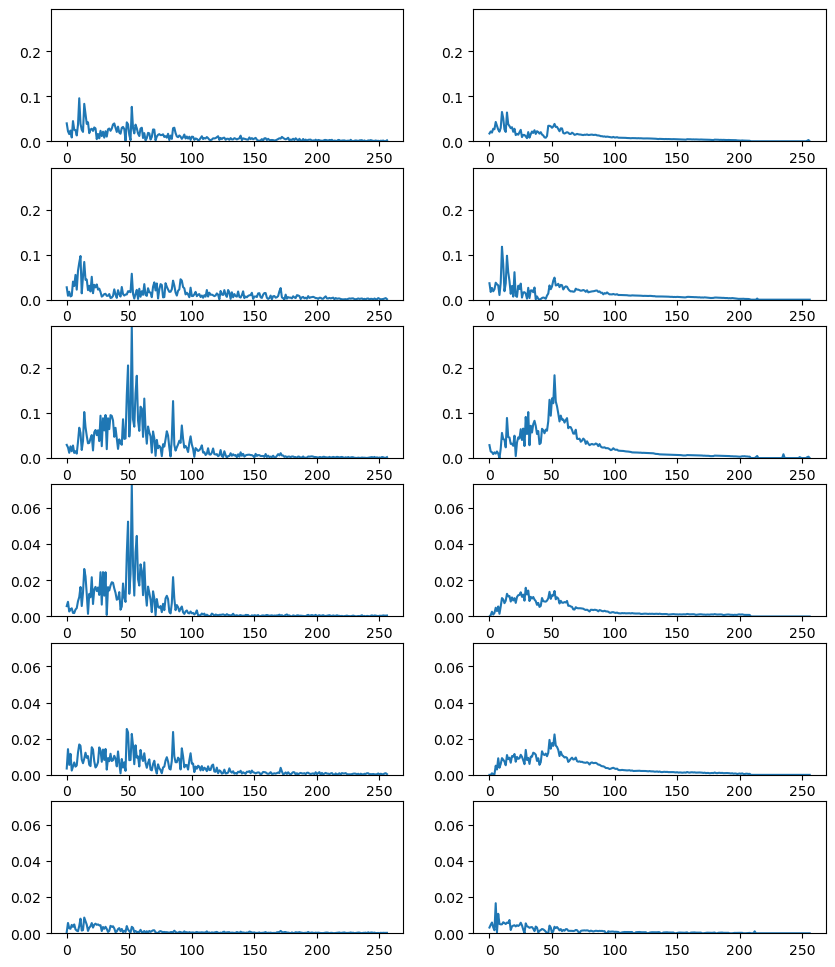

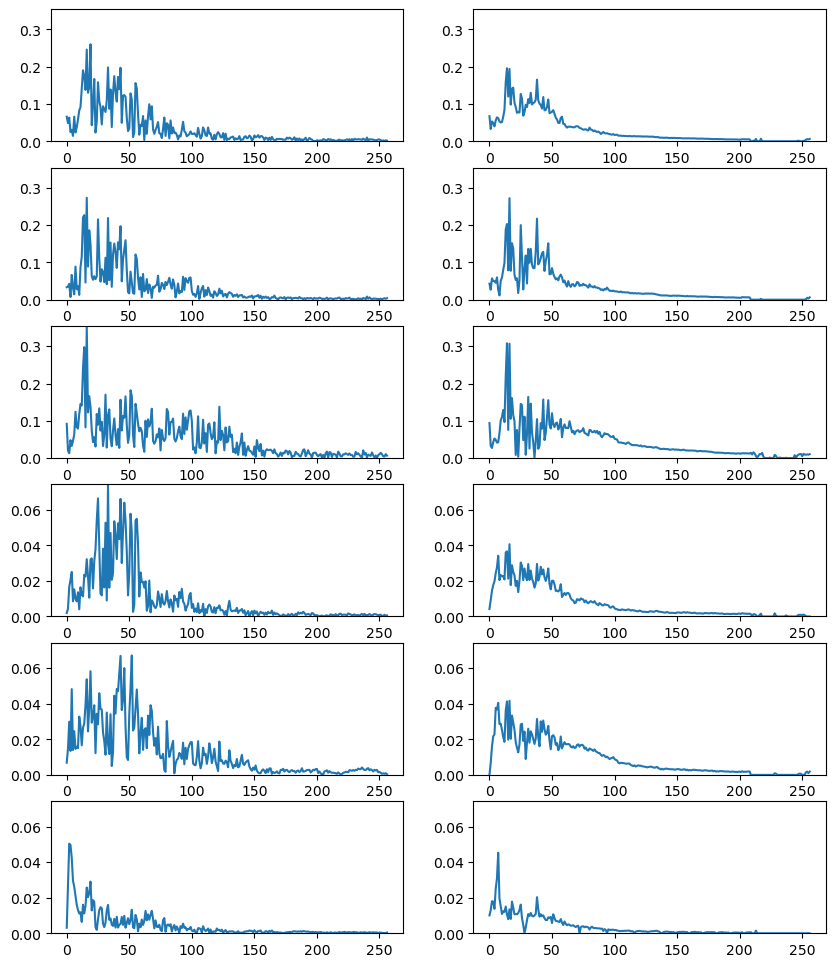

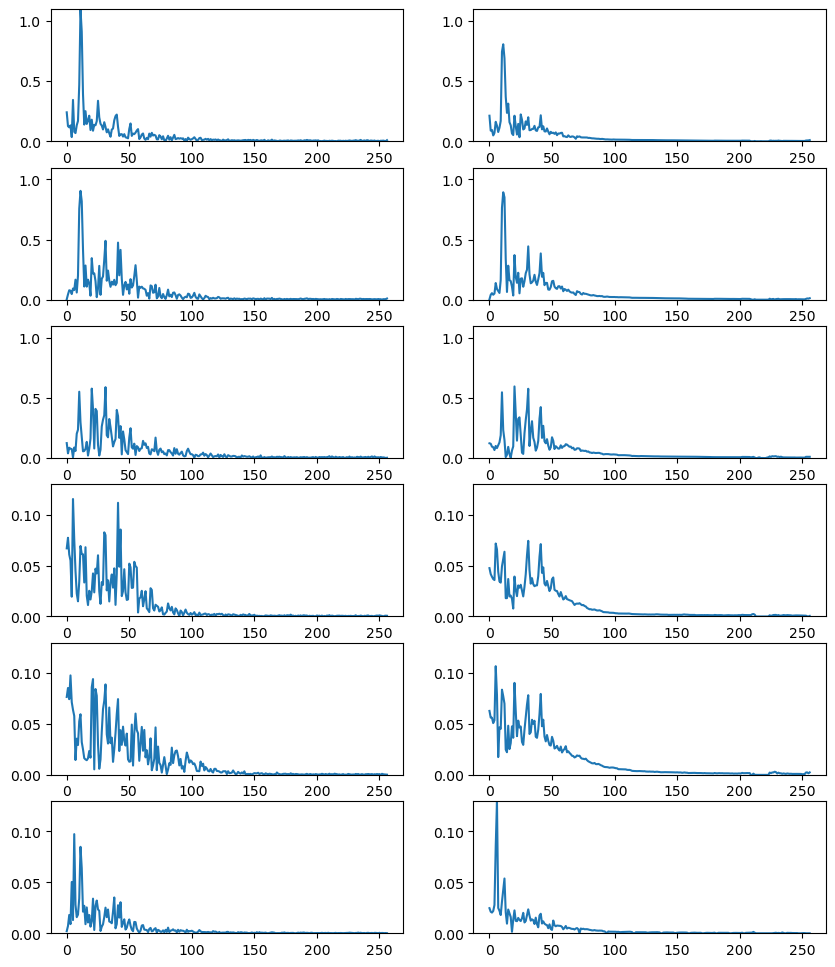

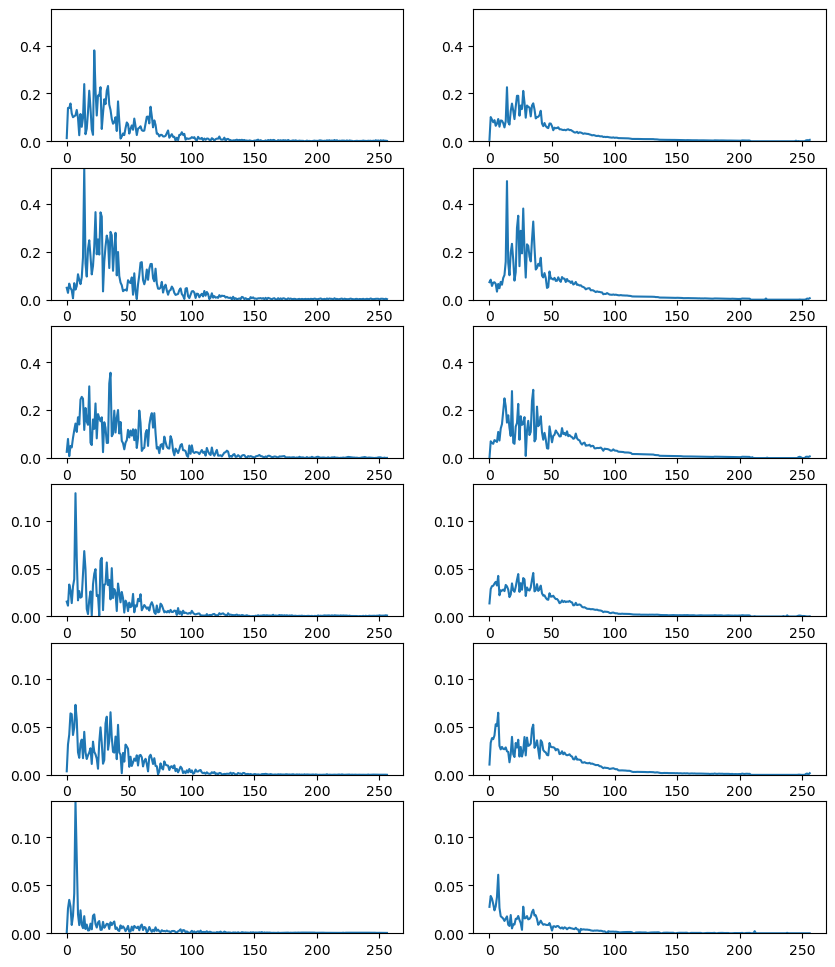

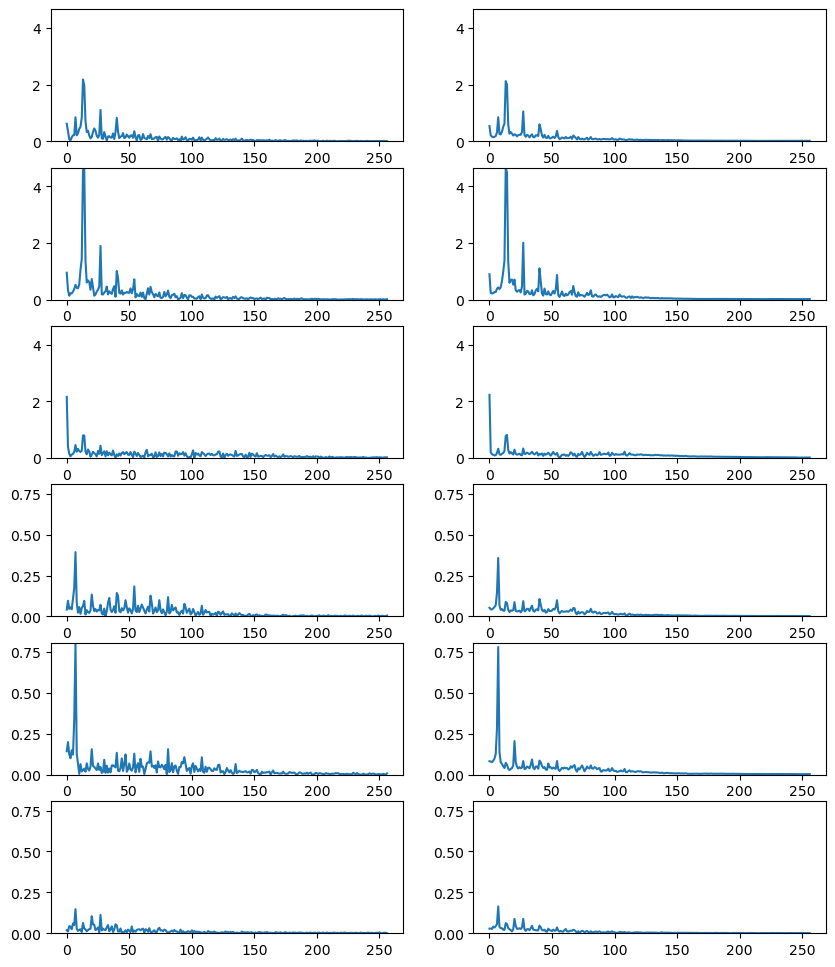

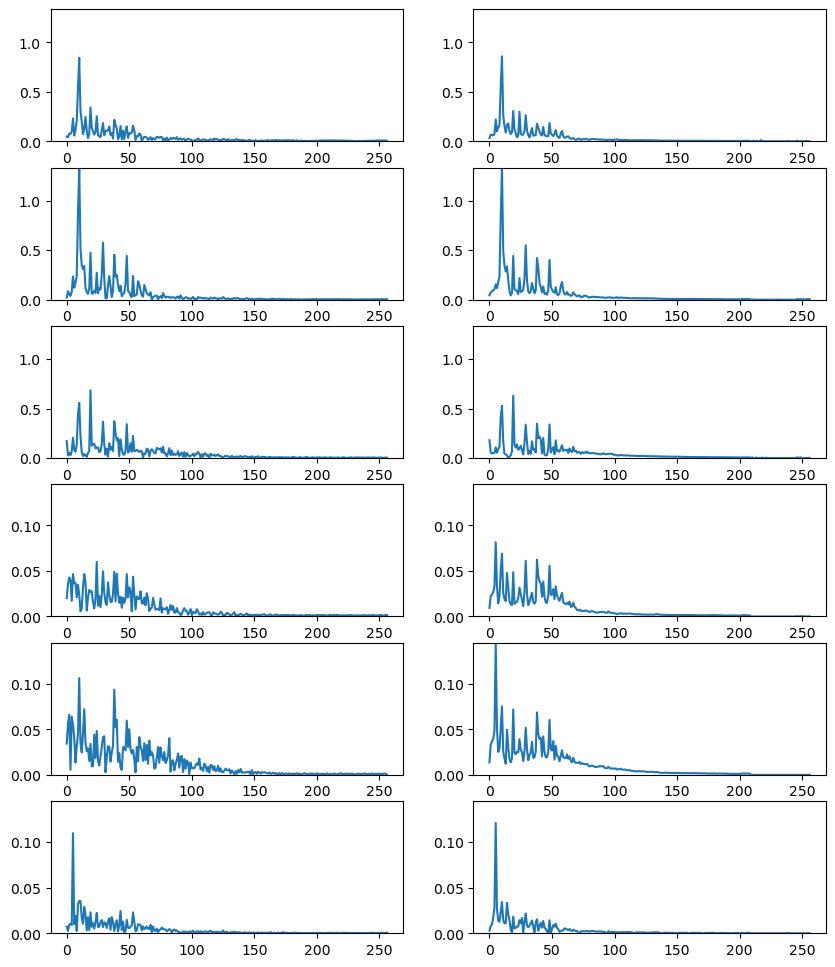

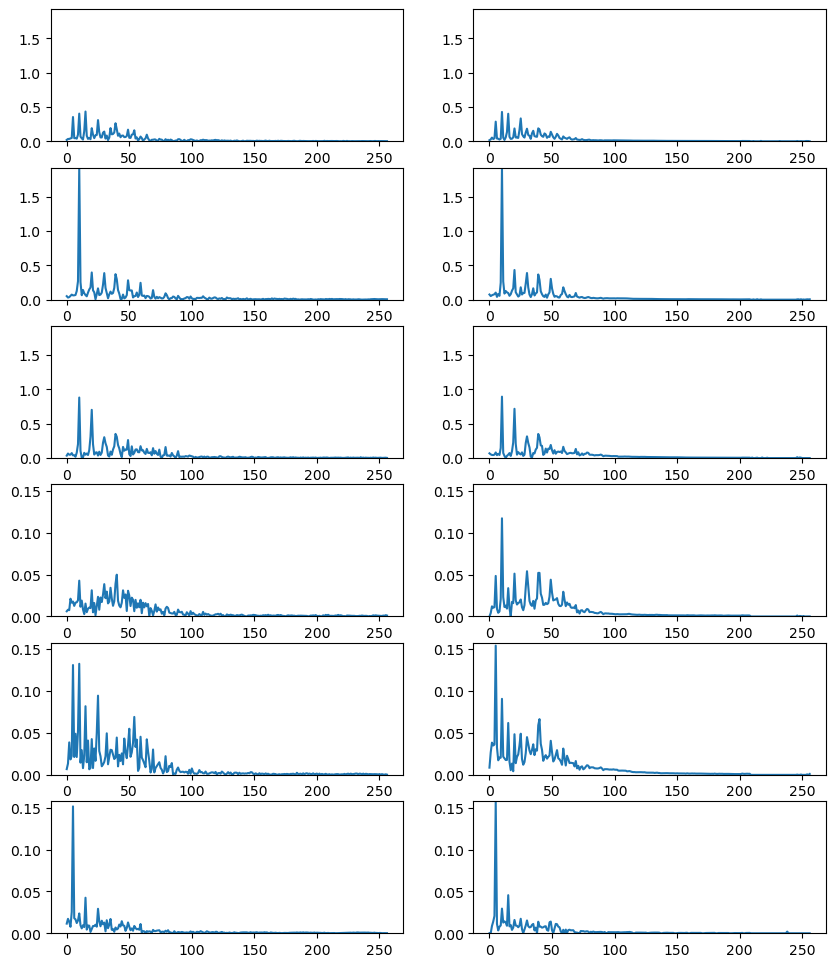

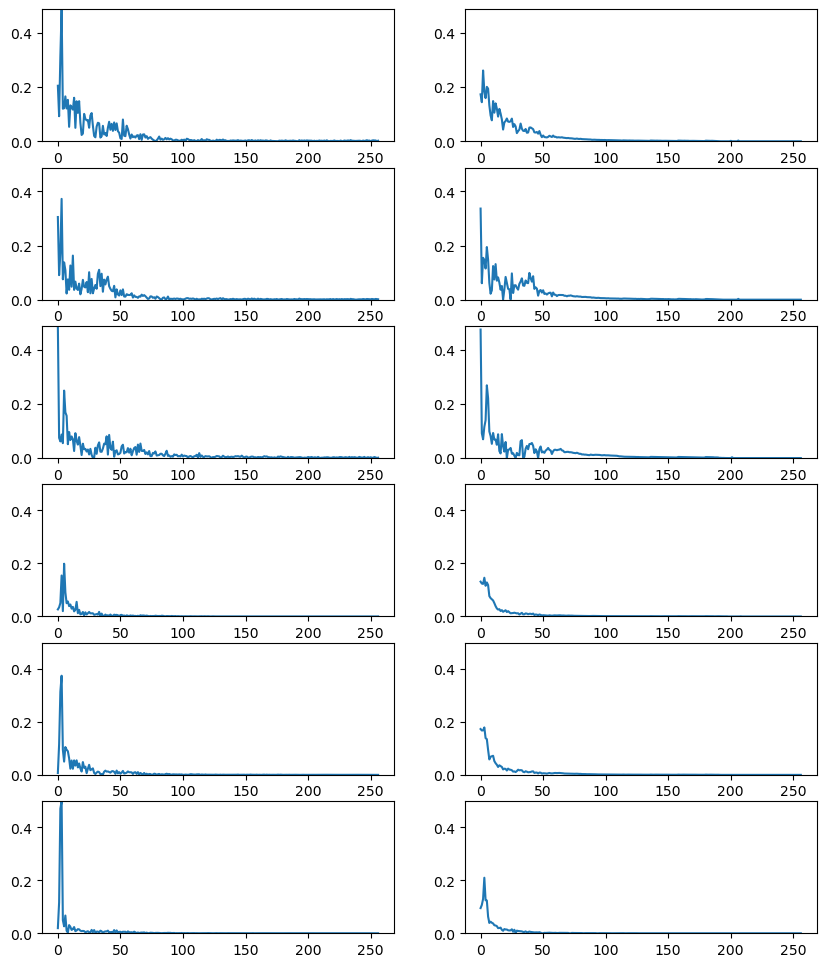

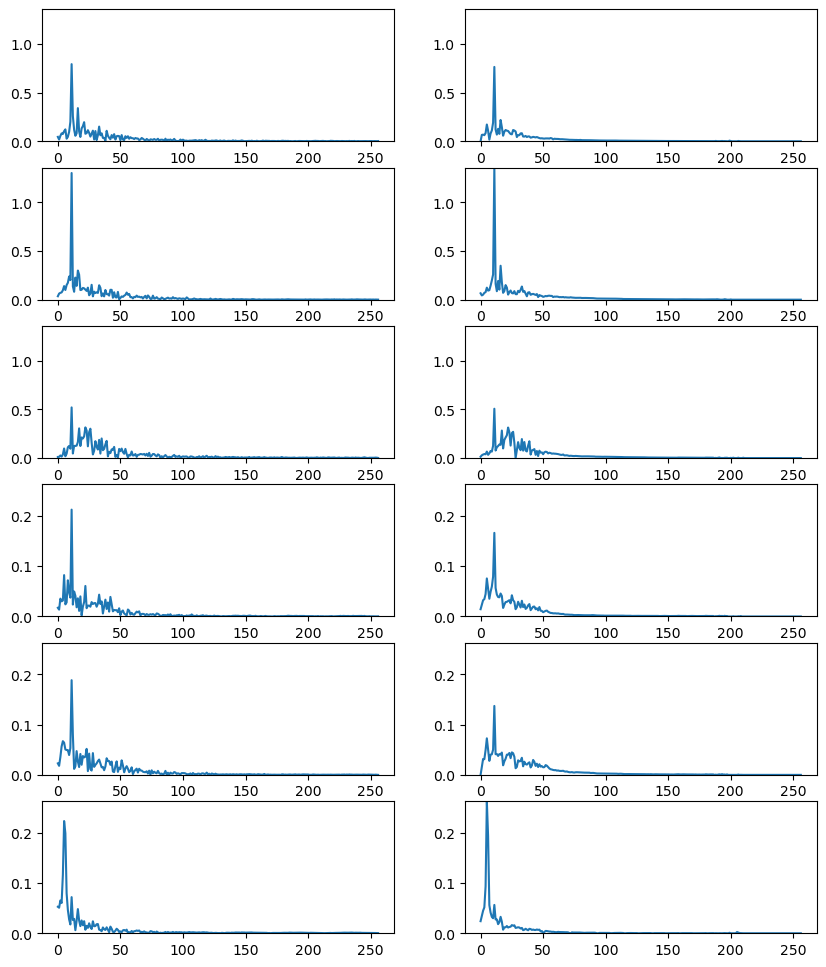

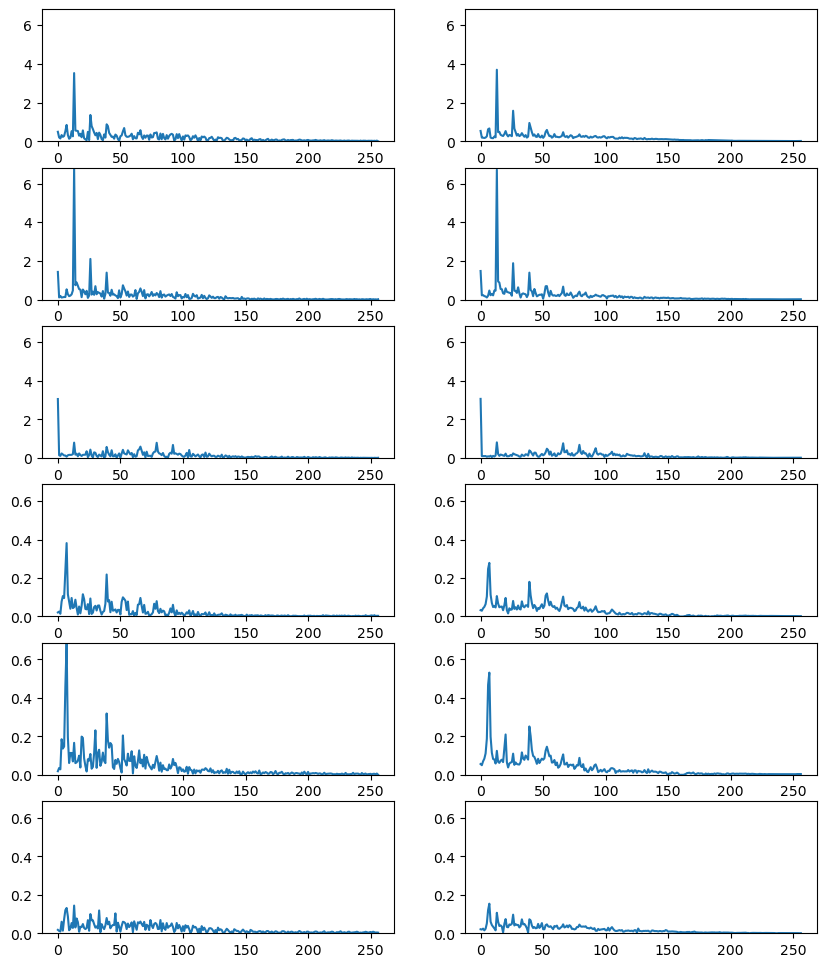

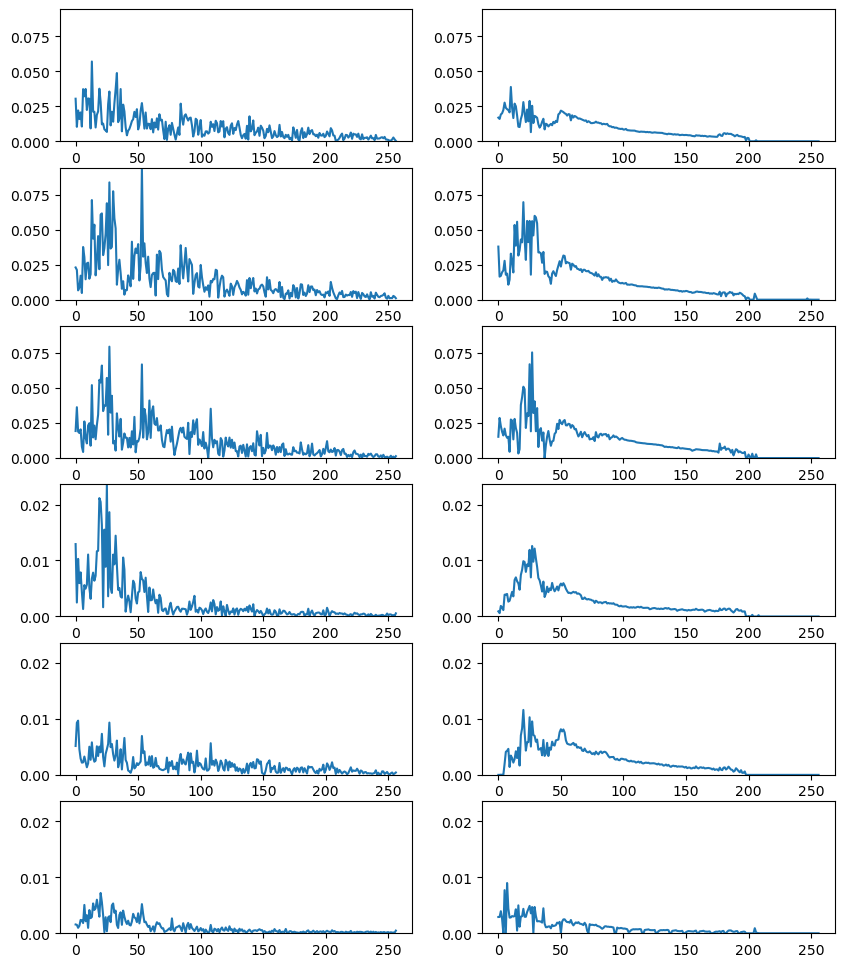

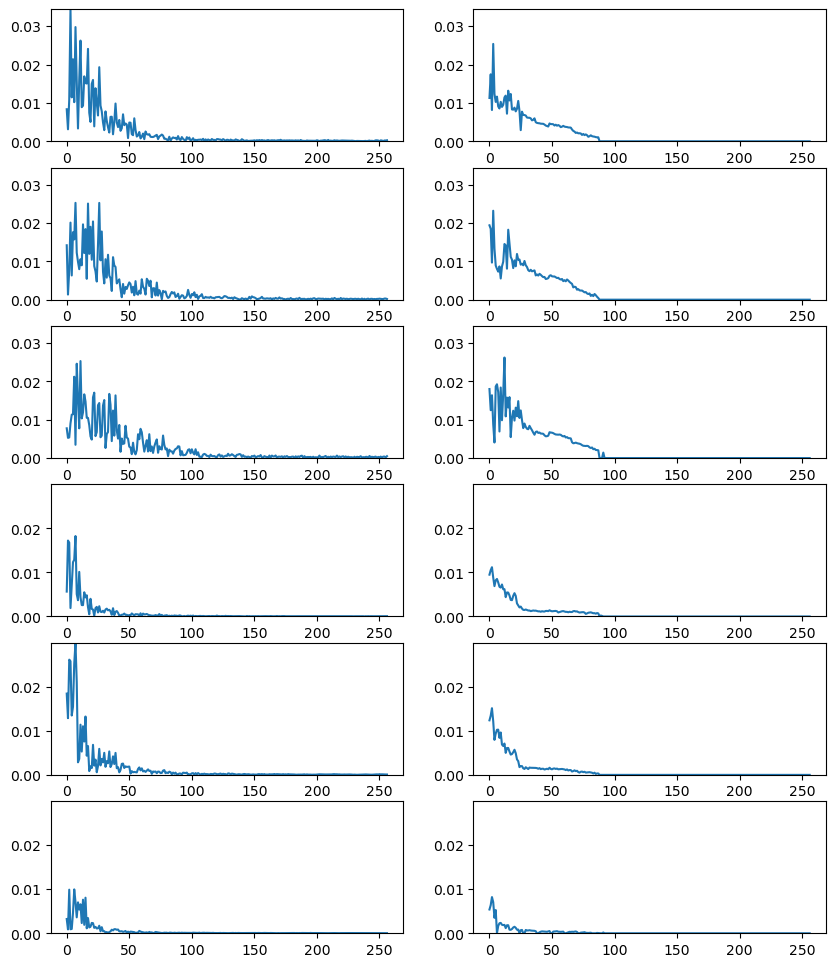

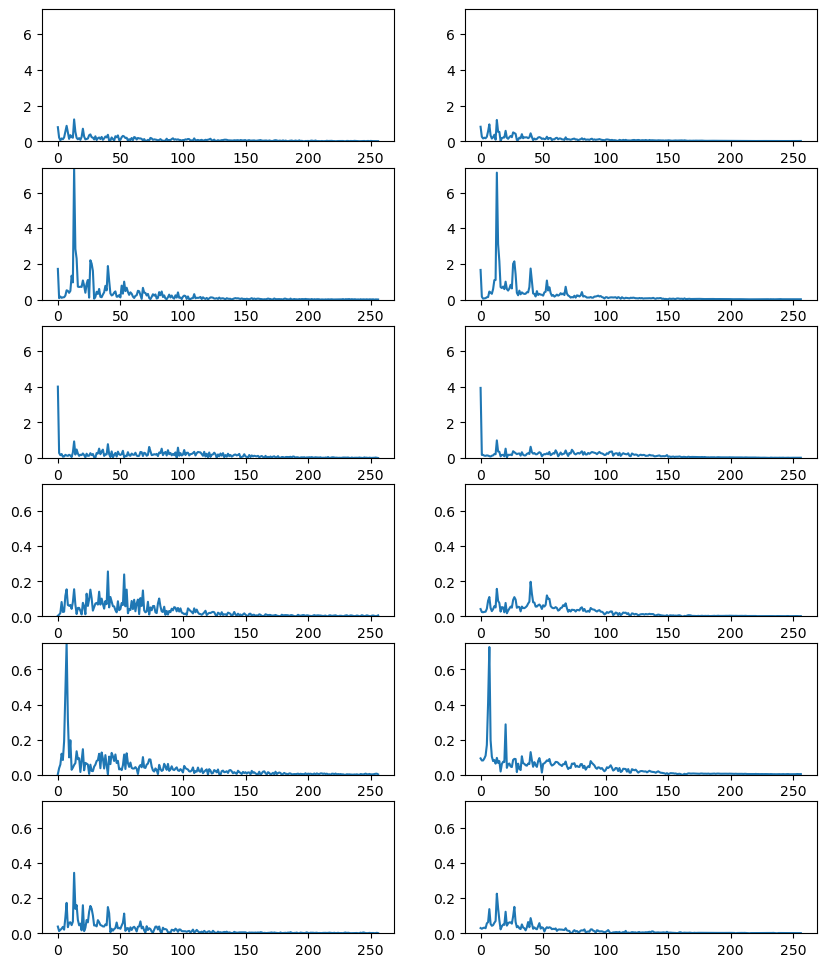

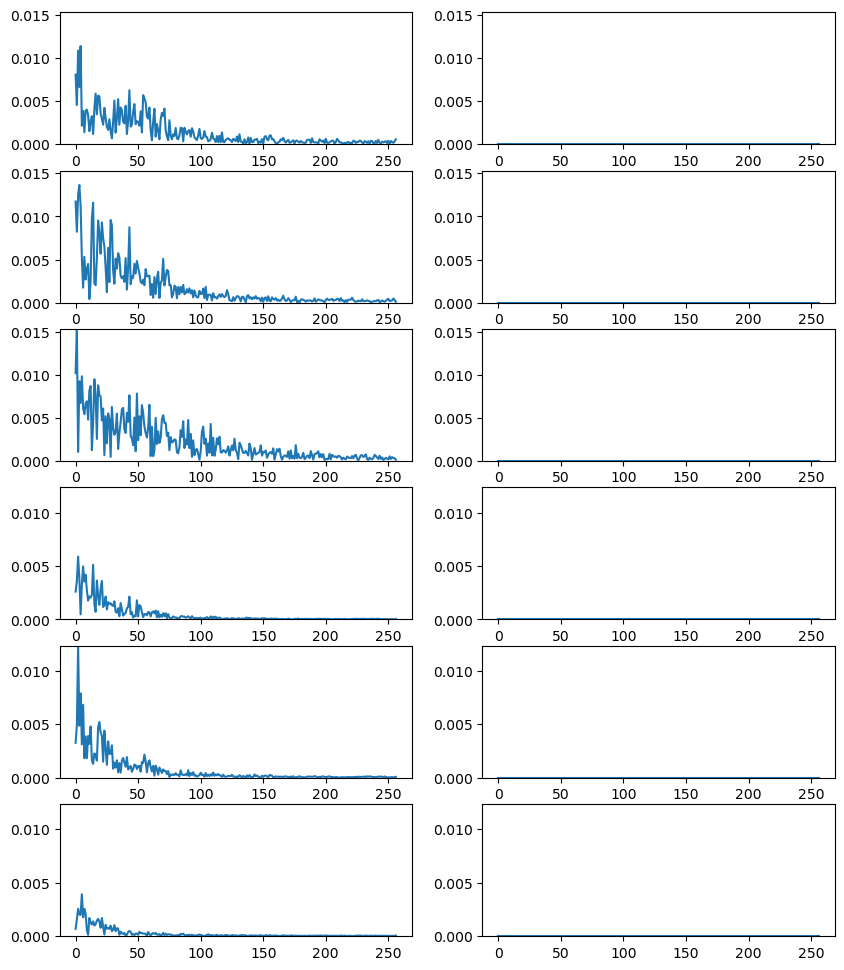

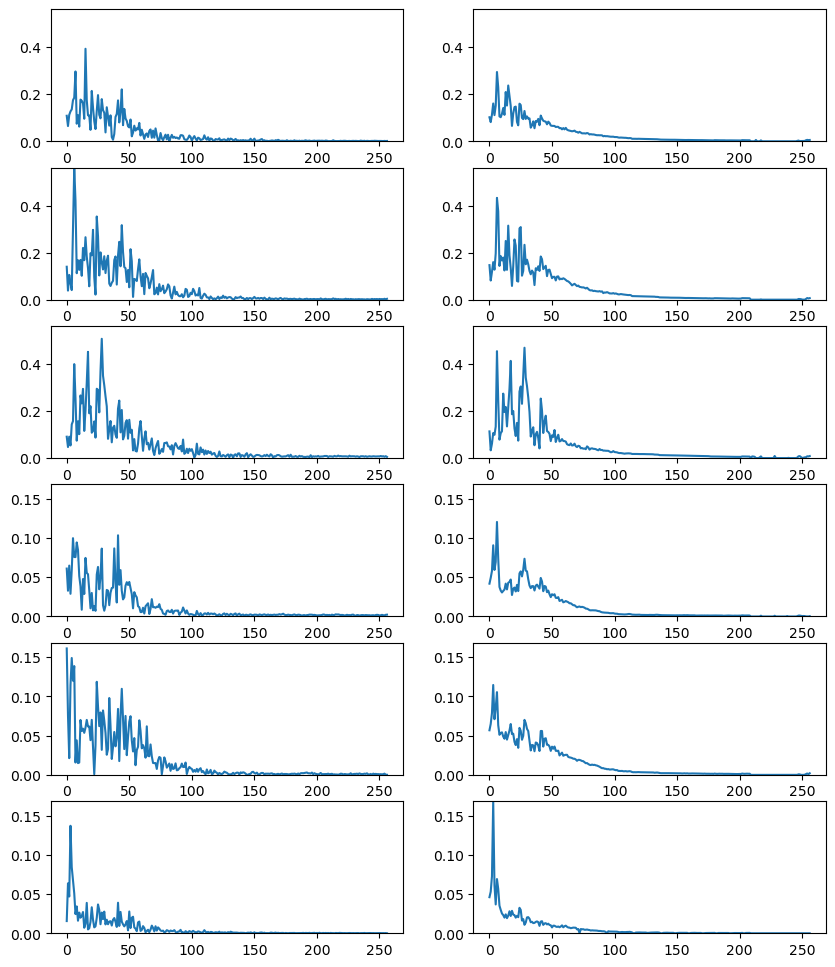

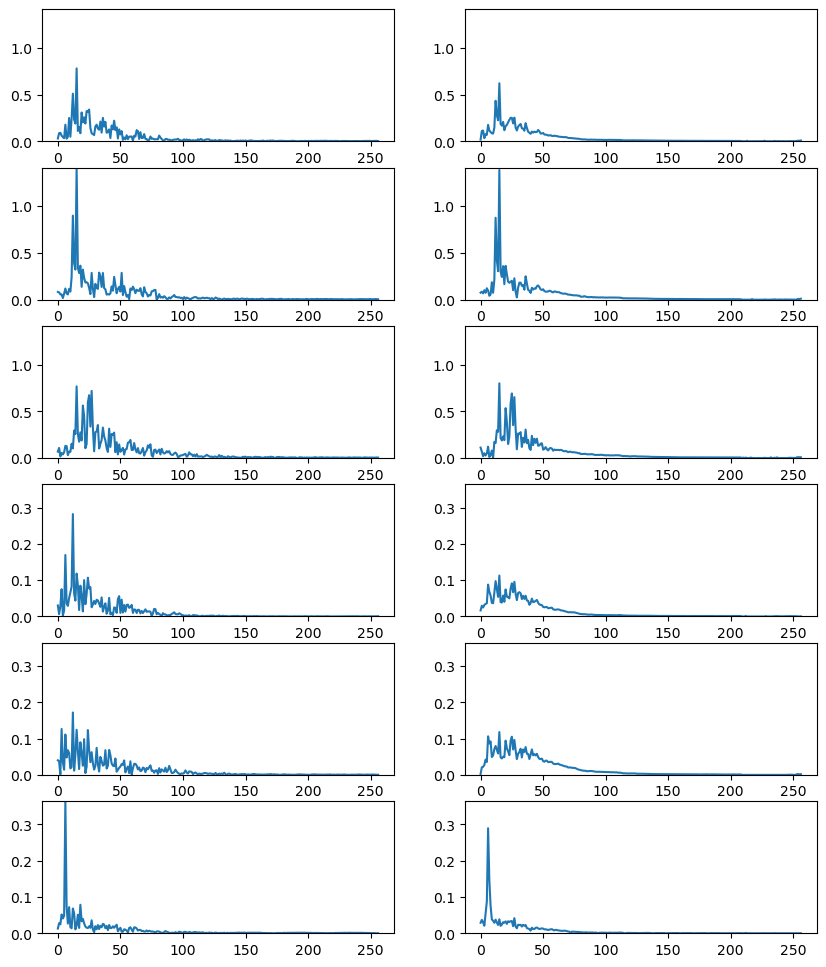

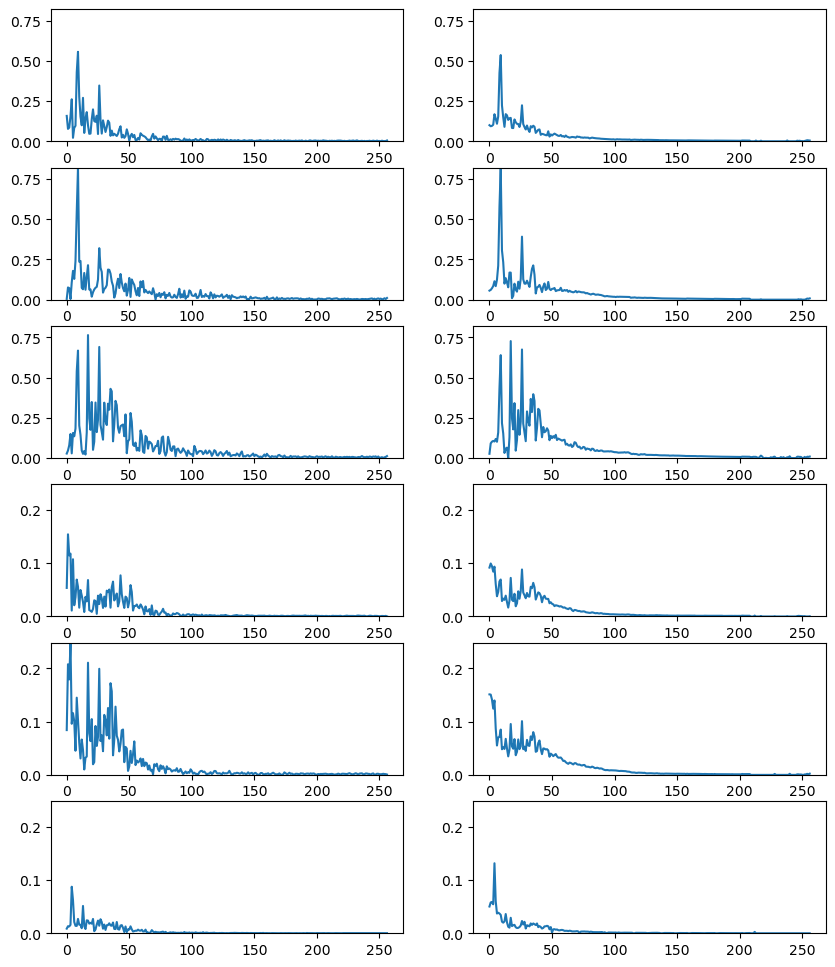

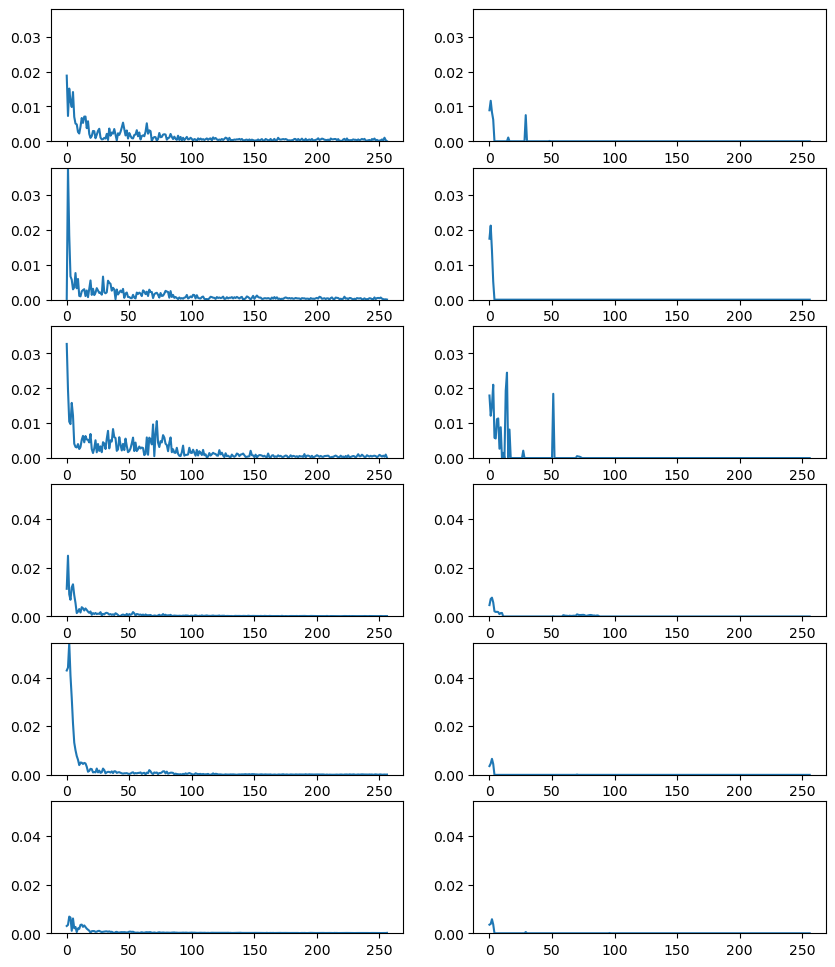

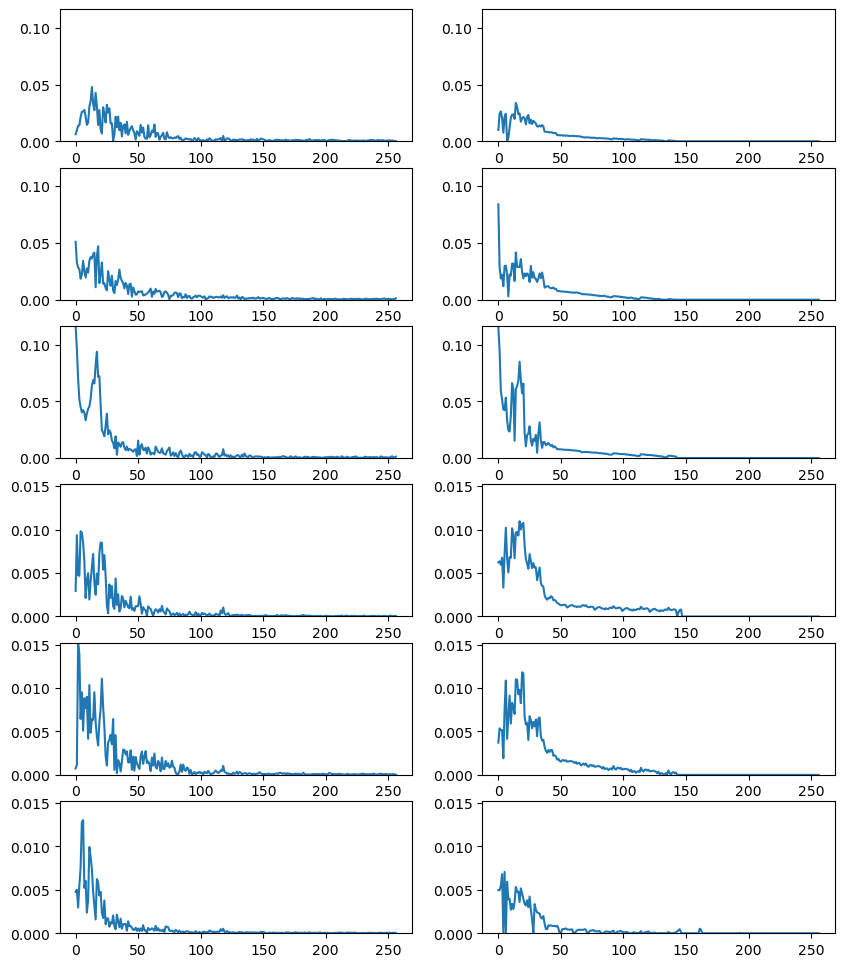

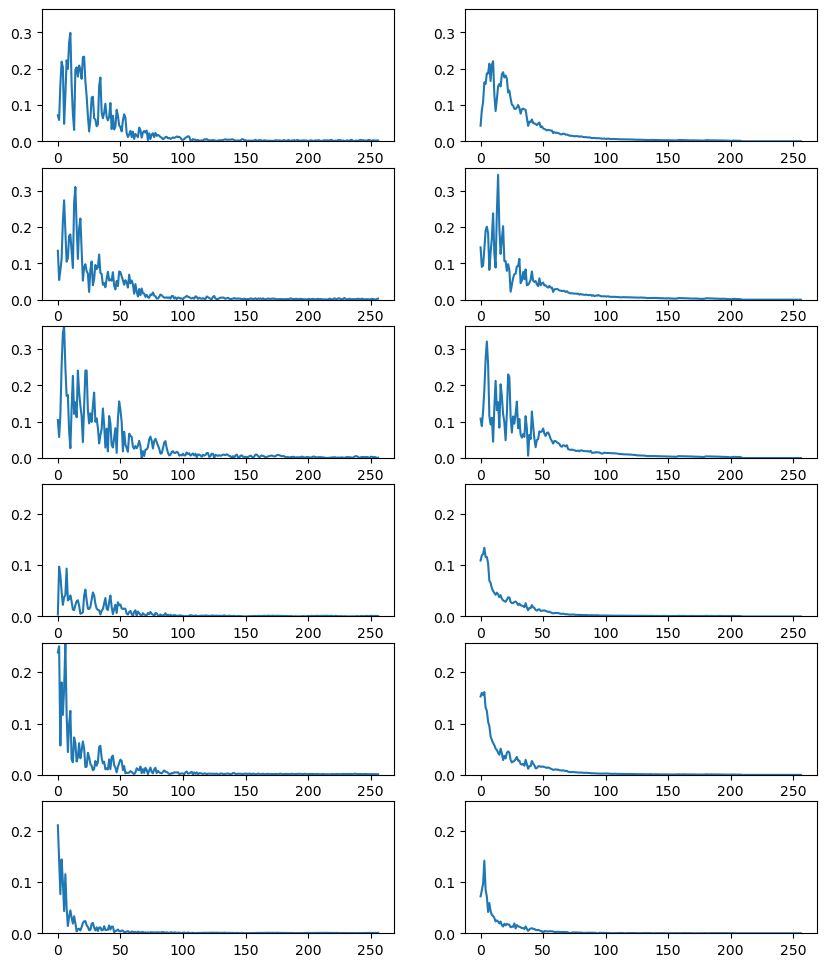

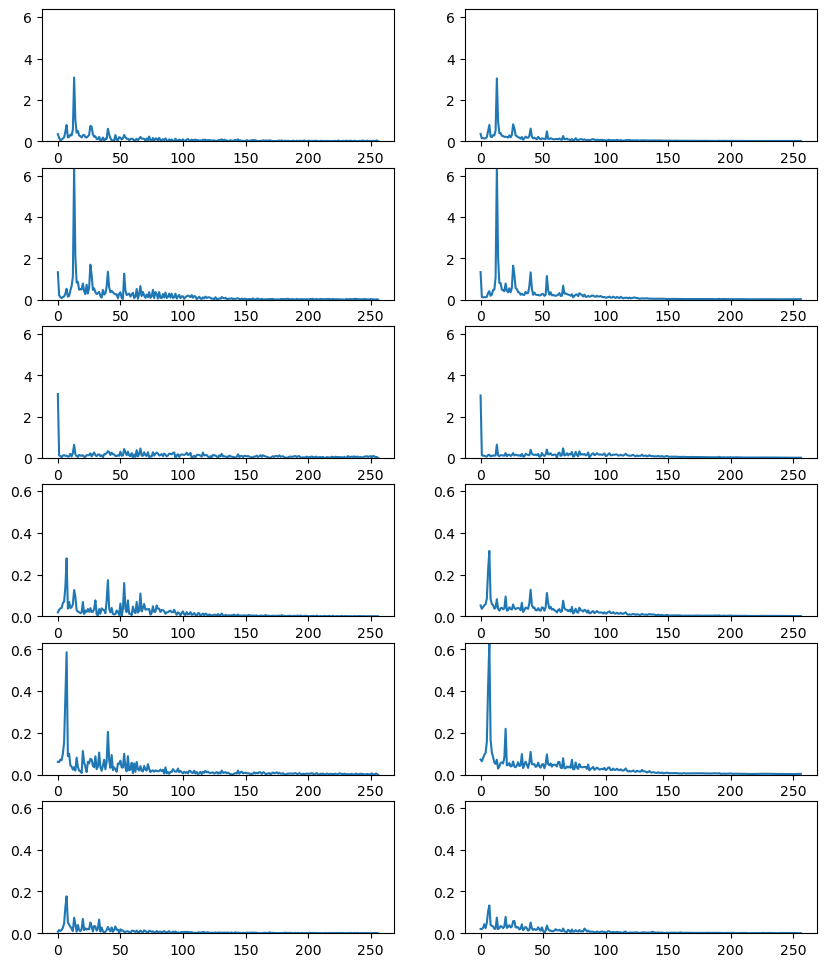

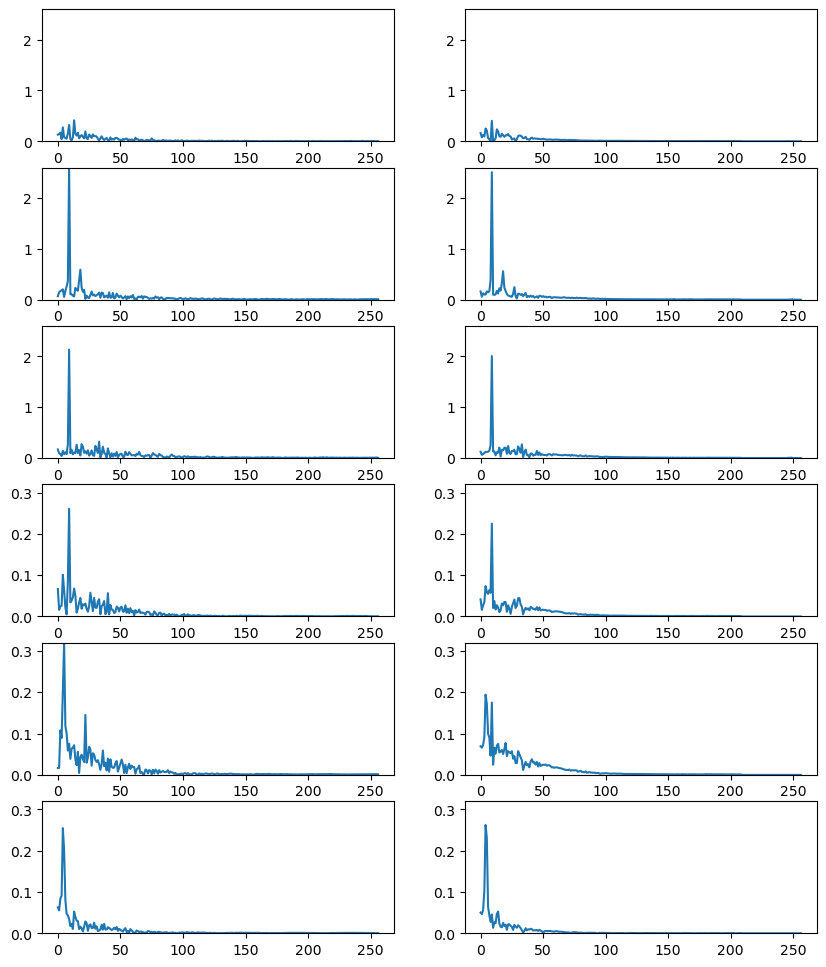

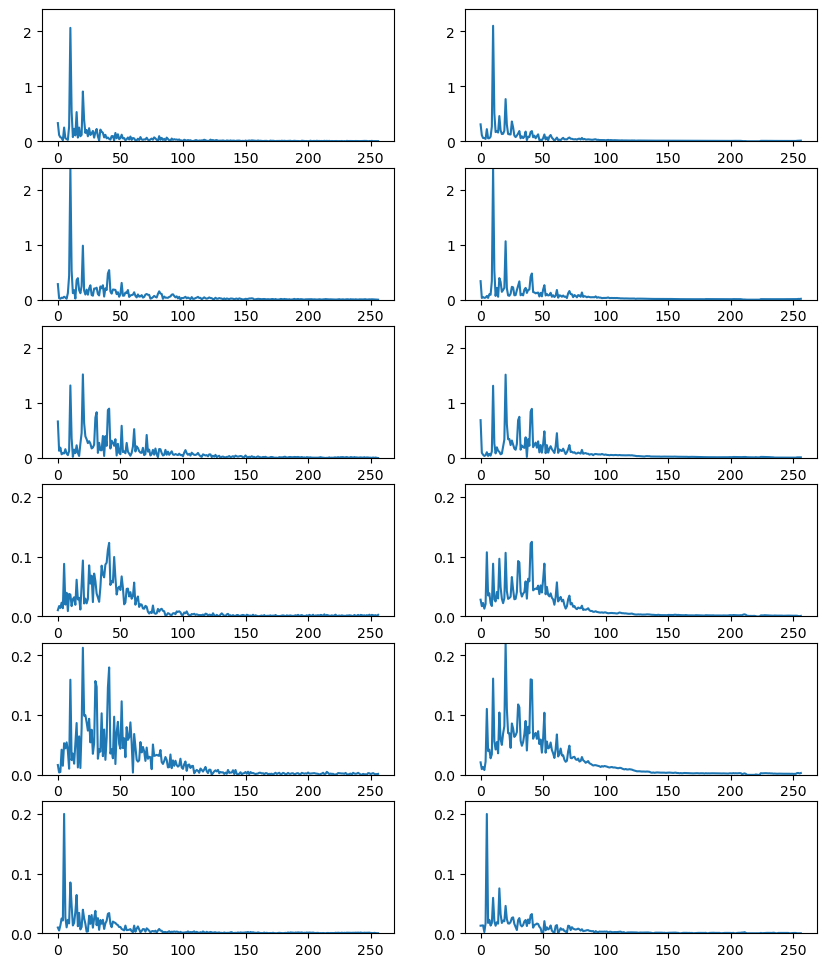

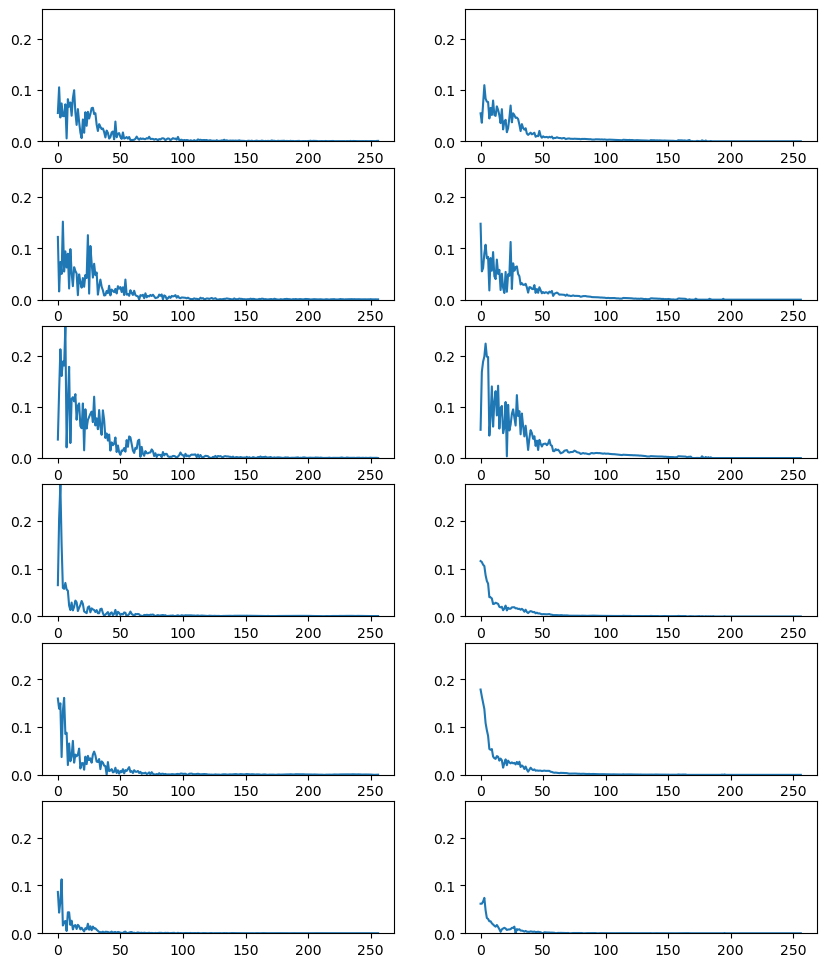

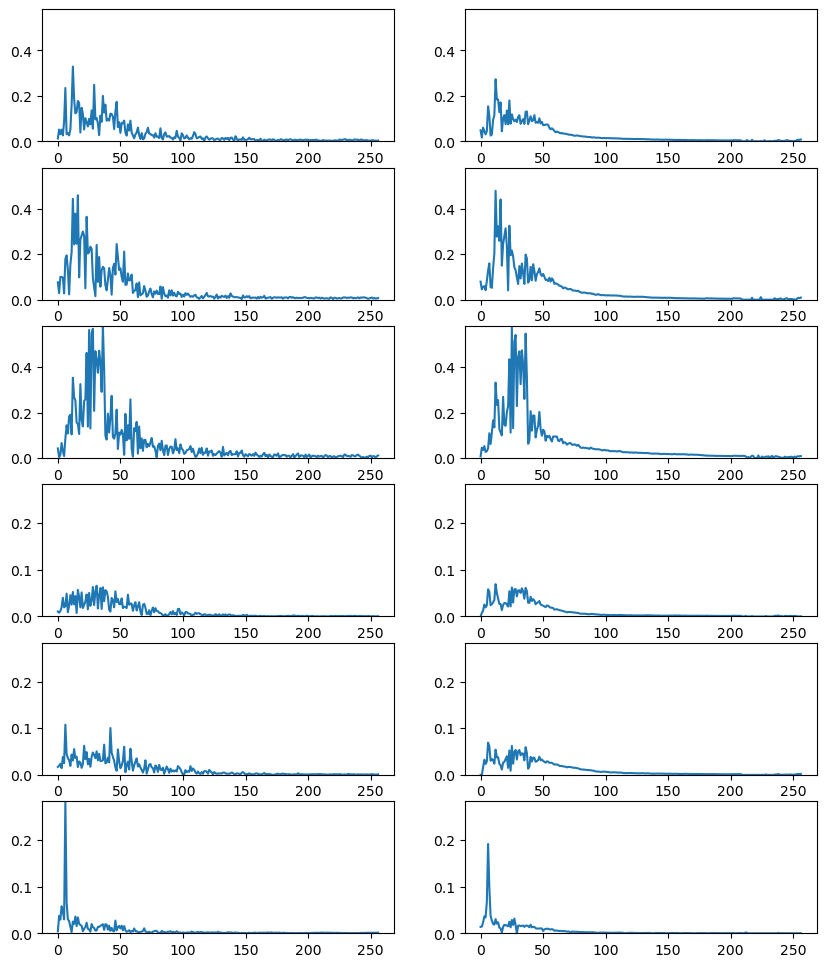

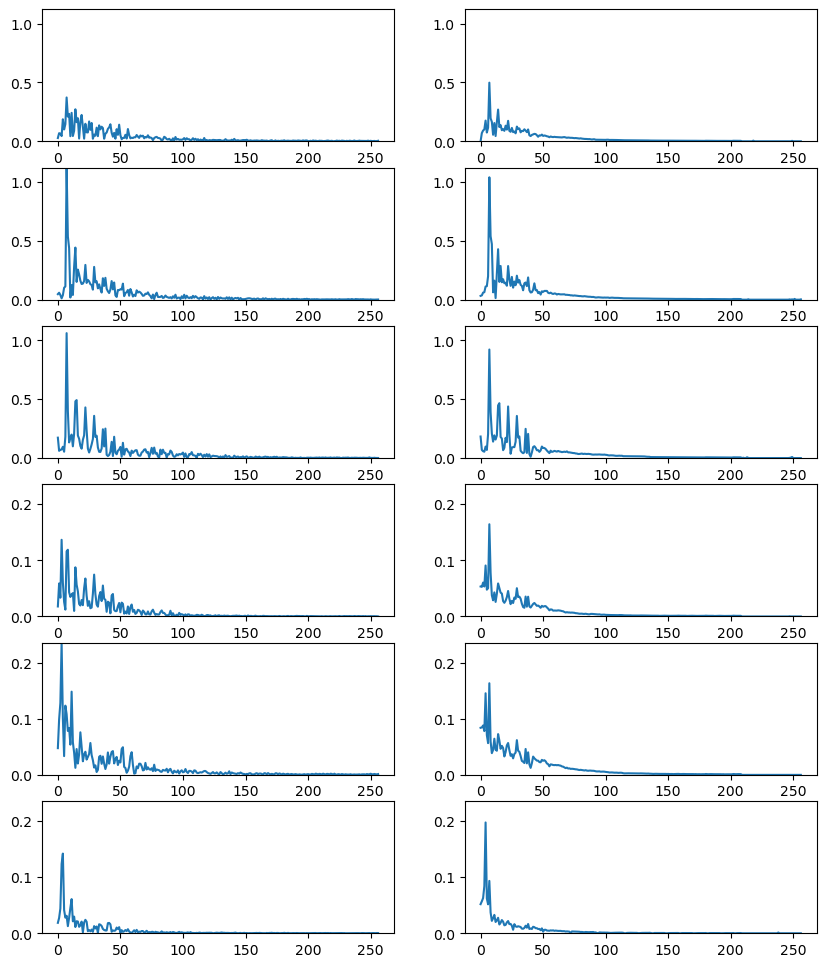

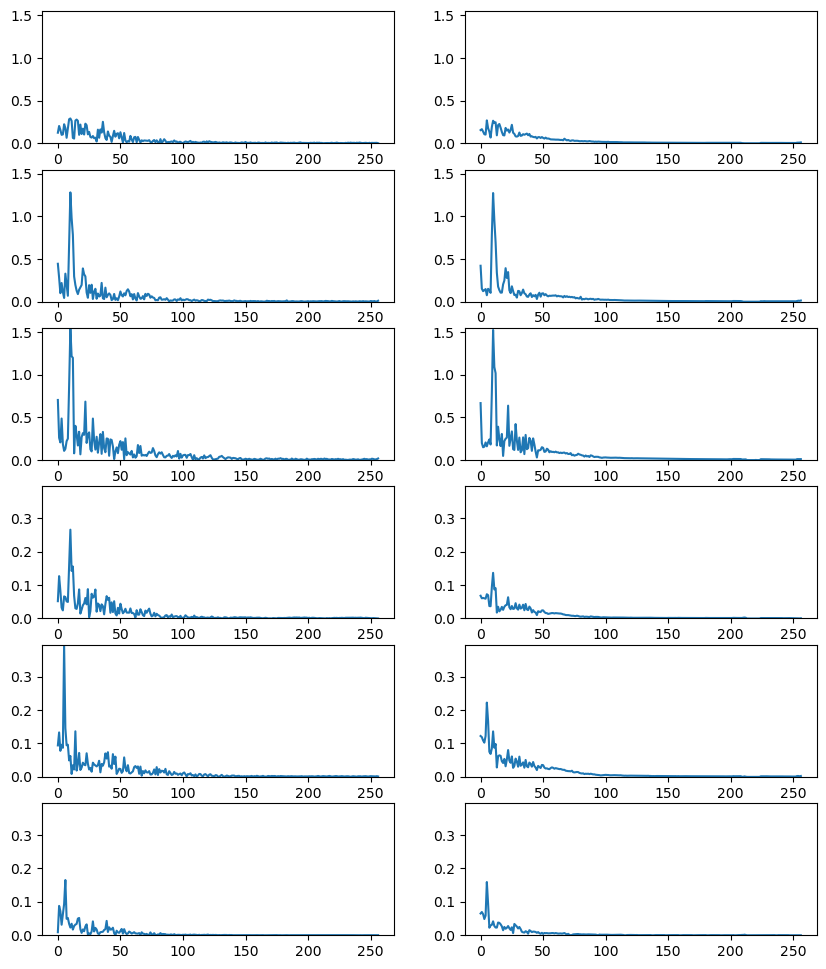

In [10]:
# %%capture --no-display
save_image_dir = os.path.join(trainer.logger.log_dir, "compare_img")
print("save_image_dir", save_image_dir)
# if os.path.isdir(save_image_dir):
#     raise ValueError()
    
os.makedirs(save_image_dir, exist_ok=True)

for batch in range(len(gt[:1])):
    for batch_img in range(len(gt[batch][:50])):
        fig, axs = plt.subplots(6,2, figsize=(10, 12))

        for i in range(6):
            axs[i,0].plot(gt[batch][batch_img][i])
            axs[i,1].plot(pred[batch][batch_img][i])

        for i in range(2):
            y_lim_list = max(np.max(gt[batch][batch_img][i*3:(i+1)*3].numpy()), np.max(pred[batch][batch_img][i*3:(i+1)*3].numpy()))
            for k in range(3):
                axs[i*3+k,0].set_ylim([0, y_lim_list])
                axs[i*3+k,1].set_ylim([0, y_lim_list])

        label = y[batch][batch_img]

        plt.savefig(os.path.join(save_image_dir, f"batch={batch}_{batch_img}_label={label}.png"))
        # plt.clf()
    